# Energy Consumption by household in the UK


## Data Preparation

First, the relevant libraries are imported, and the google drive is mounted.

In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import matplotlib
import os
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

import math

from sklearn import decomposition

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN

import warnings
warnings.filterwarnings('ignore')

<ipython-input-1-3661cbf65bf4>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## PreProcessing

In [17]:
# Importing the final dataset #
weather_energy = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario4.csv',
                             keep_default_na=False)

In [18]:
weather_energy.drop('time', axis=1, inplace=True)

Using lags of upto 12 hours we are going to convert this into a supervised problem. 

In [19]:
np.random.seed(11)
dataframe = weather_energy.loc[:,'energy(kWh/hh)']
dataset = dataframe.values
dataset = dataset.astype('float32')

Next, data is reframed to work for a supervised prediction model

In [20]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Reference: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [21]:
reframed = series_to_supervised(dataset, 24,1)
reframed.head(3)

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
24,0.127,0.178,0.352,0.215,0.135,0.091,0.112,0.893,0.453,0.237,...,1.106,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072
25,0.178,0.352,0.215,0.135,0.091,0.112,0.893,0.453,0.237,0.283,...,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091
26,0.352,0.215,0.135,0.091,0.112,0.893,0.453,0.237,0.283,0.231,...,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054


In [22]:
# Select required columns and merge with supervised data
df = weather_energy
df = df[12:]
reframed = pd.concat([df, reframed], axis=1).dropna()
reframed

,year,month,day,hour,weekday,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
24,2011,11,26,23,5,0.072,13.70,232,11.59,7.18,...,1.106,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072
25,2011,11,27,0,6,0.091,14.13,229,11.98,7.98,...,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091
26,2011,11,27,0,6,0.054,14.13,229,11.98,7.98,...,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054
27,2011,11,27,1,6,0.068,13.60,233,12.08,8.28,...,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054,0.068
28,2011,11,27,1,6,0.084,13.60,233,12.08,8.28,...,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054,0.068,0.084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39547,2014,1,30,2,3,0.080,4.78,40,4.18,2.69,...,0.341,0.085,0.827,0.070,0.720,0.198,0.322,0.115,2.586,0.080
39548,2014,2,4,5,1,0.067,13.81,225,5.63,2.26,...,0.085,0.827,0.070,0.720,0.198,0.322,0.115,2.586,0.080,0.067
39549,2014,2,9,17,6,0.406,12.15,231,6.72,-1.73,...,0.827,0.070,0.720,0.198,0.322,0.115,2.586,0.080,0.067,0.406
39550,2014,2,15,7,5,0.145,12.39,228,8.59,2.30,...,0.070,0.720,0.198,0.322,0.115,2.586,0.080,0.067,0.406,0.145


In [23]:
reframed = reframed.reindex(reframed.columns, axis=1)
reframed = reframed.values
reframed

array([[2.01100000e+03, 1.10000000e+01, 2.60000000e+01, ...,
        7.22999990e-01, 1.70000002e-01, 7.19999969e-02],
       [2.01100000e+03, 1.10000000e+01, 2.70000000e+01, ...,
        1.70000002e-01, 7.19999969e-02, 9.09999982e-02],
       [2.01100000e+03, 1.10000000e+01, 2.70000000e+01, ...,
        7.19999969e-02, 9.09999982e-02, 5.40000014e-02],
       ...,
       [2.01400000e+03, 2.00000000e+00, 9.00000000e+00, ...,
        7.99999982e-02, 6.70000017e-02, 4.05999988e-01],
       [2.01400000e+03, 2.00000000e+00, 1.50000000e+01, ...,
        6.70000017e-02, 4.05999988e-01, 1.44999996e-01],
       [2.01400000e+03, 2.00000000e+00, 1.50000000e+01, ...,
        4.05999988e-01, 1.44999996e-01, 3.47999990e-01]])

**Normalization**

The last 2 readings, corresponding to 1h, are set as the testing set, and the rest is training set

In [24]:
# split into train and test sets
train = reframed[:(len(reframed)-2), :]
test = reframed[(len(reframed)-2):len(reframed), :]

To avoid certain features on higher scales overly-affecting the model, all continous data needs to be scaled.   

In [25]:
# PreProcessing of dataset to feed to models
scaler = MinMaxScaler(feature_range=(0, 1))

Data is split between target variable and independent variables

In [26]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

The scaler must be fit on just the training set, to prevent overfitting (which means the prediction model following the trends of the training set too closely and therefore including noise in its prediction, which reduces its performance on the test set).

In [27]:
# Fit on training data and normalize it
train_X = scaler.fit_transform(train_X)

In [28]:
# Tranform the test set
test_X = scaler.transform(test_X)

In [29]:
train_X.shape

(39526, 43)

## Household energy models

Models are created separately. Lists are held with their performances, so a dataframe can be plotted at the end to compare them.

In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
R2_scores = []
MSE_scores = []
RMSE_scores = []
MAE_scores = []
MAPE_scores = []
train_times = []
models_predictions = ['MLR', 'SVM', 'RF', 'FFNNs', 'LSTM', 'RNN', 'Dense+LSTM']

### multiple linear regression (MLR)

The model is fit on the training set.

In [32]:
from sklearn import linear_model
import time
model = linear_model.LinearRegression()
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)
model.coef_

Training time: 0.048 s


array([ 2.85032473e-10,  3.32253515e-10, -2.40921763e-11,  3.71598694e-10,
        7.39014149e-11,  4.89500000e+00, -3.50459269e-10,  2.35011486e-11,
       -1.03197834e-09,  2.04103370e-09, -3.59955274e-10, -1.01633097e-09,
       -6.05231495e-11, -1.39094654e-09, -2.52608169e-09, -8.79271493e-11,
        1.19298727e-10,  7.05782842e-11, -6.64963670e-11, -5.49231068e-12,
       -1.58701231e-09,  1.40511684e-10,  1.84802337e-09, -1.21248071e-09,
       -1.99260390e-09,  1.13396162e-09,  2.50636497e-09,  5.90716645e-10,
       -1.68803511e-09, -2.21640499e-10, -6.89130401e-10, -2.95413352e-10,
       -4.76891133e-10,  1.73946530e-09,  1.75129531e-09,  1.41838002e-09,
        1.40686391e-10, -7.08618563e-10, -1.39910957e-10, -1.73927883e-09,
        3.95794122e-09,  2.44511785e-09,  2.21629643e-09])

A prediction is made on the test set.

In [33]:
# make a prediction
yhat = model.predict(test_X)

In [34]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Then, the prediction is compared to the true target feature values, and the model's performance is calculated. 

In [35]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999999999999995
Mse:  0.000000000000000
Rmse: 0.000000007376062
Mae:  0.000000006659410
Mape:  0.000002615210719
Training time: 0.048 s


In [36]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

In [37]:
import matplotlib
import seaborn as sns

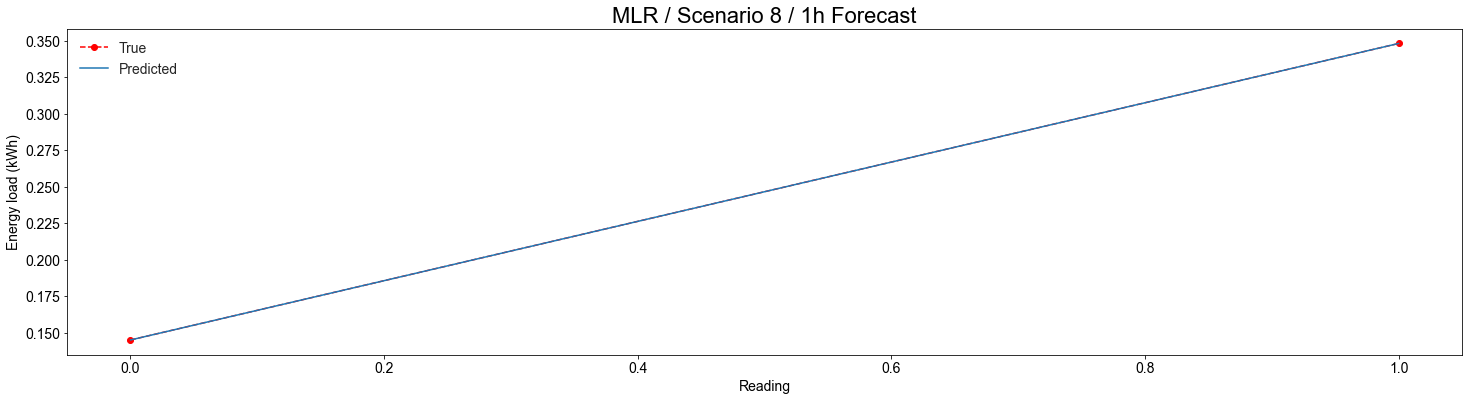

In [38]:
matplotlib.rcParams.update({'font.size': 14})
predicted_mreg = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_mreg['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_mreg['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('MLR / Scenario 8 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario8/1_allHouseholds/S8_1h_MLR.jpeg', dpi = 500)
plt.show()


The model is predicting almost perfectly.

In [39]:
from joblib import dump, load
dump(model, 'C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/MLR_Scenario4.joblib')

['C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/MLR_Scenario4.joblib']

### support vector regressor (SVR)

In [40]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR

In [41]:
model = LinearSVR(C=8, 
                  dual=False, 
                  epsilon=0.001, loss='squared_epsilon_insensitive') 
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
train_times.append(train_time)
print(f'Training time: {train_time:.3f} s') 

Training time: 0.241 s


**Prediction**

In [42]:
# make a prediction
yhat = model.predict(test_X)

In [43]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999880639713680
Mse:  0.000001216103494
Rmse: 0.001102770825581
Mae:  0.000948910810781
Mape:  0.571129937197124
Training time: 0.241 s


In [44]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

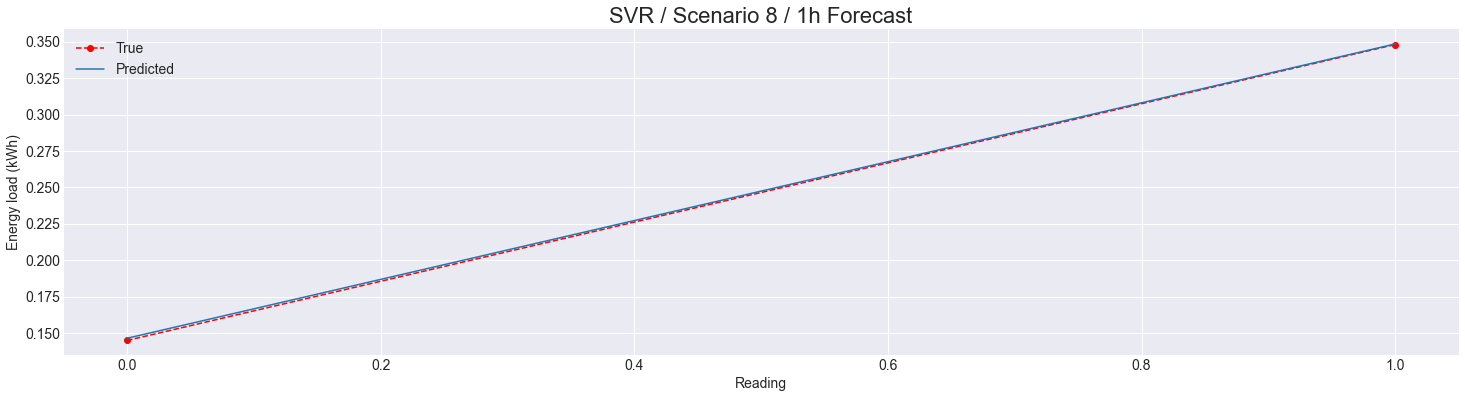

In [45]:
matplotlib.rcParams.update({'font.size': 14})
predicted_svm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_svm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_svm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('SVR / Scenario 8 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario8/1_allHouseholds/S8_1h_SVR.jpeg', dpi = 500)
plt.show()

Although the model picked up on the general trend, it clearly lacks the performance of the MLR.

In [46]:
from joblib import dump, load
dump(model, 'C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/SVR_Scenario4.joblib')

['C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/SVR_Scenario4.joblib']

### random forest (RF)

In [47]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [48]:
model = RandomForestRegressor(bootstrap= True,
                              max_depth= 110,
                              max_features= 0.33,
                              min_samples_leaf= 3,
                              min_samples_split= 10,
                              n_estimators= 100, 
                              criterion='mse')
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
train_times.append(train_time)
print(f'Training time: {train_time:.3f} s') 

Training time: 23.857 s


**Prediction**

In [49]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.reshape(yhat.shape[0],1)

**Prediction**

In [50]:
# make a prediction
yhat = model.predict(test_X)

In [51]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.970426918540234
Mse:  0.000247315345224
Rmse: 0.015726262913490
Mae:  0.012094855443706
Mape:  6.916694834000227
Training time: 23.857 s


In [52]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

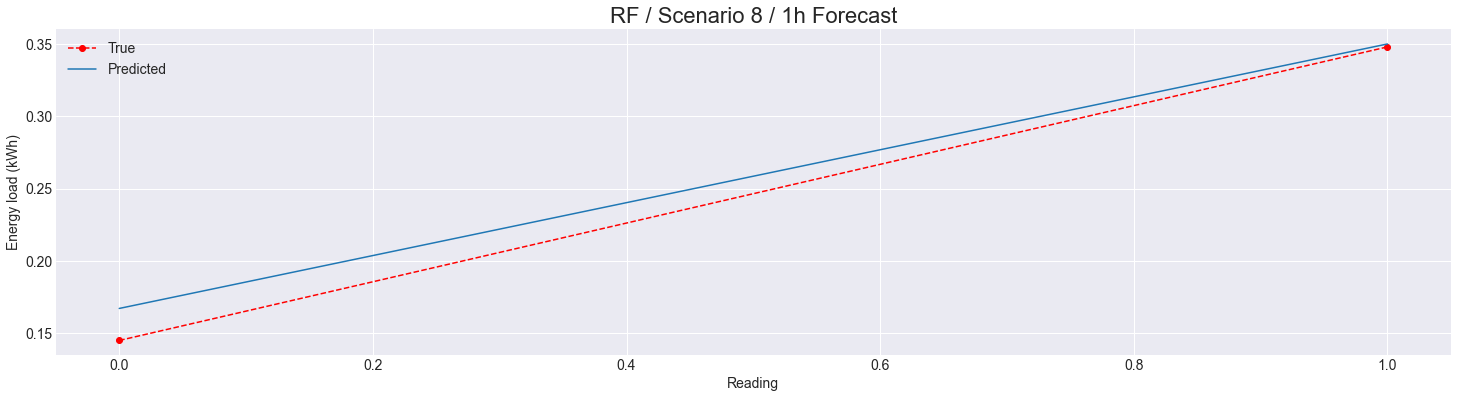

In [53]:
matplotlib.rcParams.update({'font.size': 14})
predicted_rf = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_rf['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_rf['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RF / Scenario 8 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario8/1_allHouseholds/S8_1h_RF.jpeg', dpi = 500)
plt.show()

### feedforward neural networks (FFNNs)

In [54]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(39526, 1, 43) (39526,) (2, 1, 43) (2,)


In [55]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers import GRU
from keras.layers.convolutional import MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.layers import TimeDistributed
import keras
from keras import layers

In [56]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.datasets import mnist
from keras.models import Sequential
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [57]:
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Set random seed

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import time

In [58]:
from keras.optimizers import RMSprop

Epoch 1/10
7906/7906 - 4s - loss: 0.0077
Epoch 2/10
7906/7906 - 4s - loss: 8.2425e-04
Epoch 3/10
7906/7906 - 5s - loss: 4.6530e-04
Epoch 4/10
7906/7906 - 5s - loss: 3.3360e-04
Epoch 5/10
7906/7906 - 4s - loss: 2.5105e-04
Epoch 6/10
7906/7906 - 5s - loss: 2.0017e-04
Epoch 7/10
7906/7906 - 5s - loss: 1.6966e-04
Epoch 8/10
7906/7906 - 6s - loss: 1.4624e-04
Epoch 9/10
7906/7906 - 6s - loss: 1.3428e-04
Epoch 10/10
7906/7906 - 5s - loss: 1.2385e-04


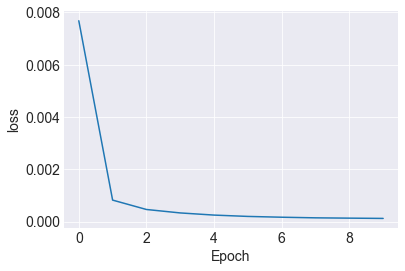

Training time: 49.977 s


In [59]:
model = Sequential()

# Add fully connected layer with a ReLU activation function
model.add(Dense(units=64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(units=64, activation='relu'))

# Add fully connected layer with no activation function
model.add(Dense(units=1))

optimizer = keras.optimizers.RMSprop(lr=0.001, momentum= 0.9)

model.compile(loss='mean_squared_error', # Mean squared error
            optimizer ='RMSprop' # Optimization algorithm
            )

start_time = time.time()
history = model.fit(train_X, train_y, epochs=10, batch_size=5, verbose=2, shuffle=False) 
end_time = time.time()
train_time = end_time - start_time
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

**Prediction**

In [60]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [61]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.974636260042102
Mse:  0.000241749451343
Rmse: 0.015548294161845
Mae:  0.015058554708958
Mape:  7.056378603762596
Training time: 49.977 s


In [62]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

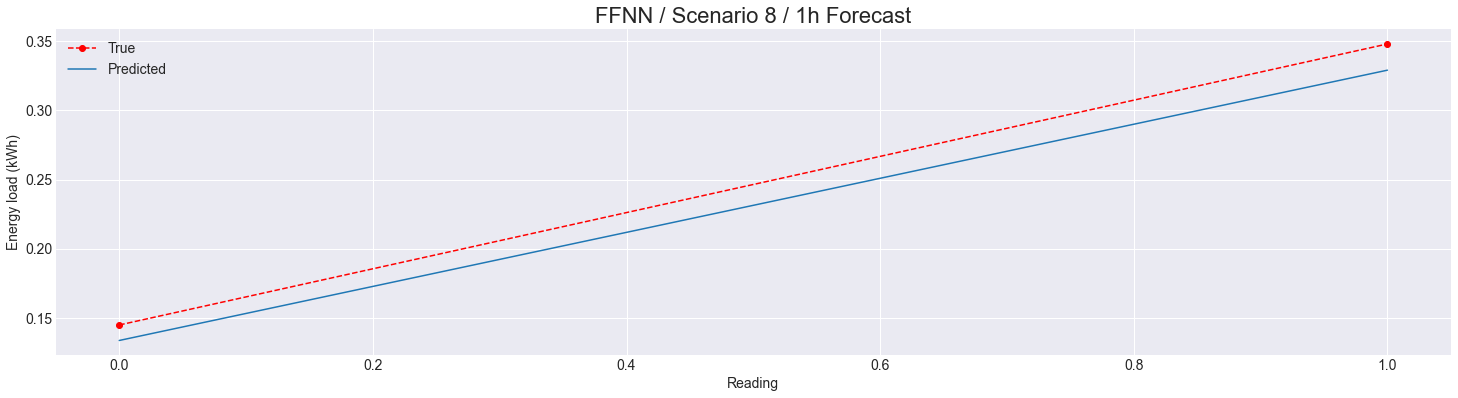

In [63]:
matplotlib.rcParams.update({'font.size': 14})
predicted_fnn = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_fnn['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_fnn['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('FFNN / Scenario 8 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario8/1_allHouseholds/S8_1h_FFNN.jpeg', dpi = 500)
plt.show()

Good predictions, although a bit worse compared to the RF.

### LSTM

In [64]:
from keras.wrappers.scikit_learn import KerasRegressor
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Set random seed

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import time

In [65]:
from keras.optimizers import Adam

Epoch 1/30
1647/1647 - 2s - loss: 0.0380 - acc: 0.0037
Epoch 2/30
1647/1647 - 2s - loss: 0.0024 - acc: 0.0037
Epoch 3/30
1647/1647 - 2s - loss: 0.0011 - acc: 0.0037
Epoch 4/30
1647/1647 - 2s - loss: 0.0012 - acc: 0.0037
Epoch 5/30
1647/1647 - 2s - loss: 0.0020 - acc: 0.0037
Epoch 6/30
1647/1647 - 2s - loss: 7.6834e-04 - acc: 0.0037
Epoch 7/30
1647/1647 - 2s - loss: 7.7978e-04 - acc: 0.0037
Epoch 8/30
1647/1647 - 2s - loss: 7.7051e-04 - acc: 0.0037
Epoch 9/30
1647/1647 - 2s - loss: 7.2125e-04 - acc: 0.0037
Epoch 10/30
1647/1647 - 2s - loss: 0.0013 - acc: 0.0037
Epoch 11/30
1647/1647 - 2s - loss: 1.4818e-04 - acc: 0.0037
Epoch 12/30
1647/1647 - 2s - loss: 6.4176e-04 - acc: 0.0037
Epoch 13/30
1647/1647 - 2s - loss: 6.0568e-04 - acc: 0.0037
Epoch 14/30
1647/1647 - 2s - loss: 9.6423e-04 - acc: 0.0037
Epoch 15/30
1647/1647 - 3s - loss: 2.4309e-04 - acc: 0.0037
Epoch 16/30
1647/1647 - 2s - loss: 6.0514e-04 - acc: 0.0037
Epoch 17/30
1647/1647 - 3s - loss: 4.5025e-04 - acc: 0.0037
Epoch 18/30
1

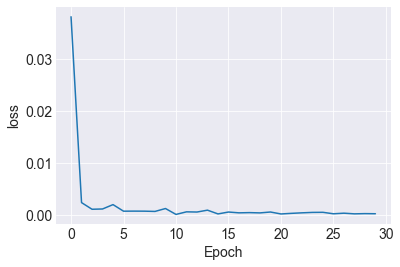

Training time: 63.081 s


In [66]:
# design network
model = Sequential()
model.add(LSTM(128,  activation='softplus', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

optimizer = Adam(lr=0.001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )


model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc']) #mae

start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=24, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

**Prediction**

In [67]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [68]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.996812065818441
Mse:  0.000034005591376
Rmse: 0.005831431331644
Mae:  0.005552798509598
Mape:  2.299601621780153
Training time: 63.081 s


In [69]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

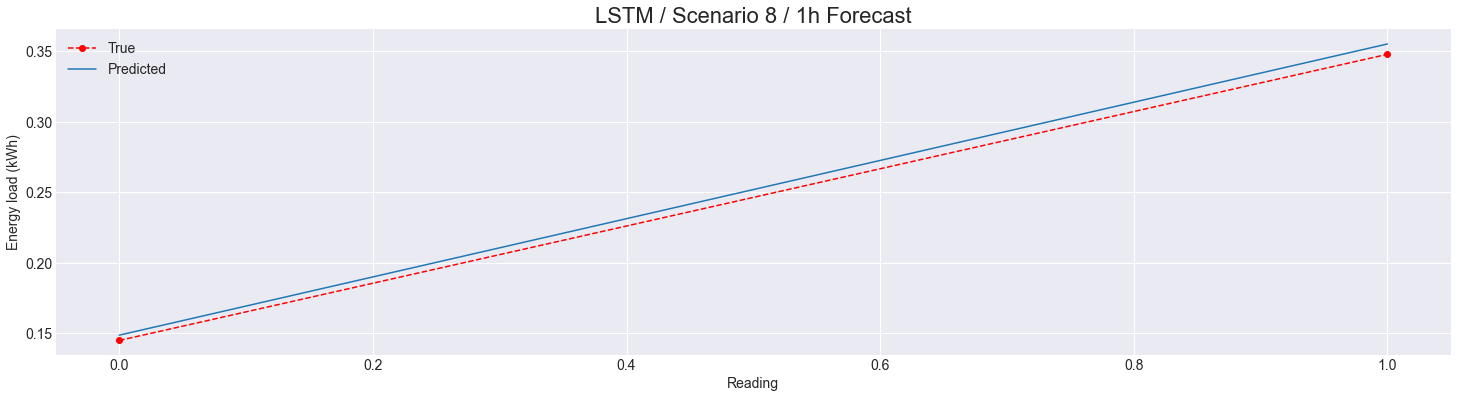

In [70]:
matplotlib.rcParams.update({'font.size': 14})
predicted_lstm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_lstm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_lstm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('LSTM / Scenario 8 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario8/1_allHouseholds/S8_1h_LSTM.jpeg', dpi = 500)
plt.show()

The model is doing well, better than the previous NN, however not as good as MLR and RF.

### RNN

In [71]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.datasets import mnist
from keras.models import Sequential
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

Epoch 1/30
1647/1647 - 1s - loss: 0.0243
Epoch 2/30
1647/1647 - 1s - loss: 0.0022
Epoch 3/30
1647/1647 - 1s - loss: 0.0021
Epoch 4/30
1647/1647 - 2s - loss: 0.0022
Epoch 5/30
1647/1647 - 1s - loss: 6.7707e-04
Epoch 6/30
1647/1647 - 1s - loss: 7.2696e-04
Epoch 7/30
1647/1647 - 1s - loss: 0.0012
Epoch 8/30
1647/1647 - 1s - loss: 7.3917e-04
Epoch 9/30
1647/1647 - 2s - loss: 7.6876e-04
Epoch 10/30
1647/1647 - 1s - loss: 7.1847e-04
Epoch 11/30
1647/1647 - 2s - loss: 7.0500e-04
Epoch 12/30
1647/1647 - 1s - loss: 4.7163e-04
Epoch 13/30
1647/1647 - 1s - loss: 6.4193e-04
Epoch 14/30
1647/1647 - 1s - loss: 4.6986e-04
Epoch 15/30
1647/1647 - 1s - loss: 5.3687e-04
Epoch 16/30
1647/1647 - 2s - loss: 4.3196e-04
Epoch 17/30
1647/1647 - 1s - loss: 4.1293e-04
Epoch 18/30
1647/1647 - 2s - loss: 1.6951e-04
Epoch 19/30
1647/1647 - 1s - loss: 3.3253e-04
Epoch 20/30
1647/1647 - 1s - loss: 2.6108e-04
Epoch 21/30
1647/1647 - 1s - loss: 3.0698e-04
Epoch 22/30
1647/1647 - 1s - loss: 2.8536e-04
Epoch 23/30
1647/

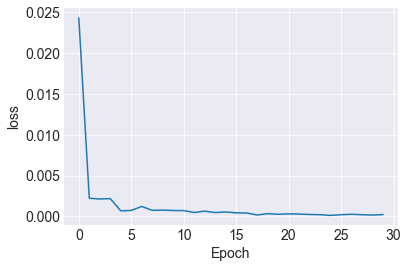

Training time: 43.103 s


In [72]:
# design network
model = Sequential()
model.add(SimpleRNN(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

optimizer = Adam(lr=0.001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )


start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=24, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

**Prediction**

In [73]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [74]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.707375787763963
Mse:  0.002811146457056
Rmse: 0.053020245727983
Mae:  0.052905499935150
Mape:  35.521138542617301
Training time: 43.103 s


In [75]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

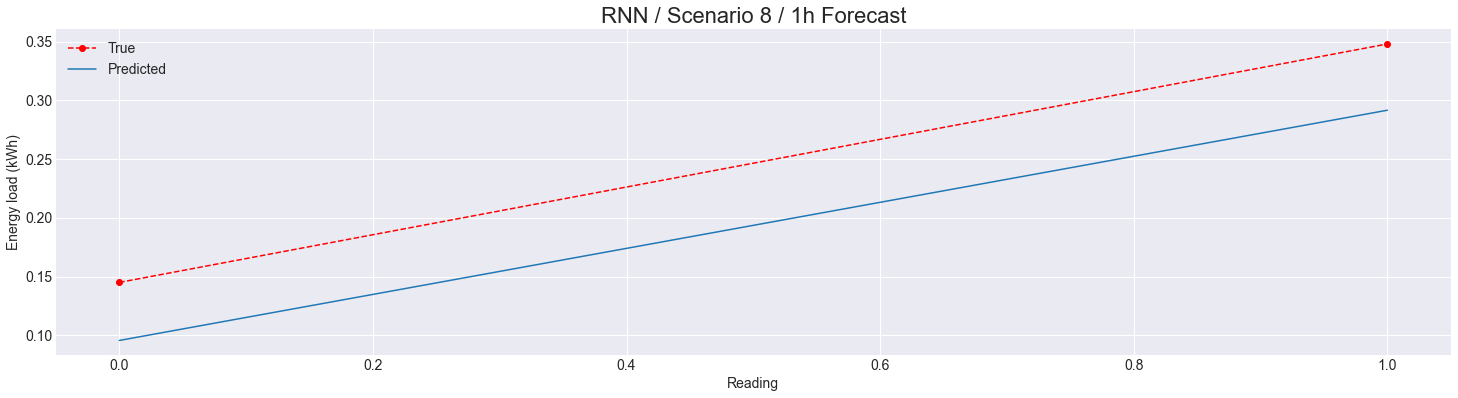

In [76]:
matplotlib.rcParams.update({'font.size': 14})
predicted_rnn = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_rnn['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_rnn['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RNN / Scenario 8 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario8/1_allHouseholds/S8_1h_RNN.jpeg', dpi = 500)
plt.show()

The model is doing well however its accuracy is worse than that of CNN-LSTM. However, it's training 4 times faster. 

Because this model achieved the best performance, saving it:

### Dense + LSTM

Epoch 1/30
618/618 - 1s - loss: 0.0865
Epoch 2/30
618/618 - 1s - loss: 0.0464
Epoch 3/30
618/618 - 1s - loss: 0.0063
Epoch 4/30
618/618 - 1s - loss: 0.0013
Epoch 5/30
618/618 - 1s - loss: 9.5393e-04
Epoch 6/30
618/618 - 1s - loss: 7.9088e-04
Epoch 7/30
618/618 - 1s - loss: 6.7487e-04
Epoch 8/30
618/618 - 1s - loss: 6.5753e-04
Epoch 9/30
618/618 - 1s - loss: 5.8518e-04
Epoch 10/30
618/618 - 1s - loss: 5.3906e-04
Epoch 11/30
618/618 - 1s - loss: 5.0482e-04
Epoch 12/30
618/618 - 1s - loss: 4.7474e-04
Epoch 13/30
618/618 - 1s - loss: 4.4853e-04
Epoch 14/30
618/618 - 1s - loss: 4.2627e-04
Epoch 15/30
618/618 - 1s - loss: 4.1112e-04
Epoch 16/30
618/618 - 1s - loss: 3.8897e-04
Epoch 17/30
618/618 - 1s - loss: 3.7202e-04
Epoch 18/30
618/618 - 1s - loss: 3.6000e-04
Epoch 19/30
618/618 - 1s - loss: 3.4051e-04
Epoch 20/30
618/618 - 1s - loss: 3.3125e-04
Epoch 21/30
618/618 - 1s - loss: 3.1475e-04
Epoch 22/30
618/618 - 1s - loss: 3.0445e-04
Epoch 23/30
618/618 - 1s - loss: 2.9257e-04
Epoch 24/30
6

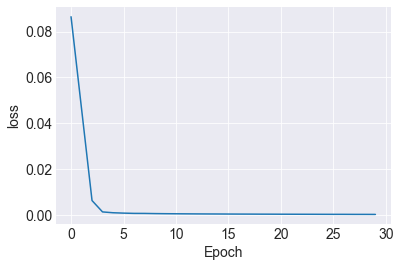

Training time: 39.511 s


In [77]:
# design network
model = Sequential()
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(LSTM(128))
model.add(Dense(1))
optimizer = Adam(lr=0.0001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )


start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=64, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

In [78]:
model.save('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/dense_LSTM_Scenario4_1h.h5')

**Prediction**

In [79]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [80]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.996763797827734
Mse:  0.000031813954121
Rmse: 0.005640385990416
Mae:  0.005127340555191
Mape:  2.074245737257085
Training time: 39.511 s


In [81]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

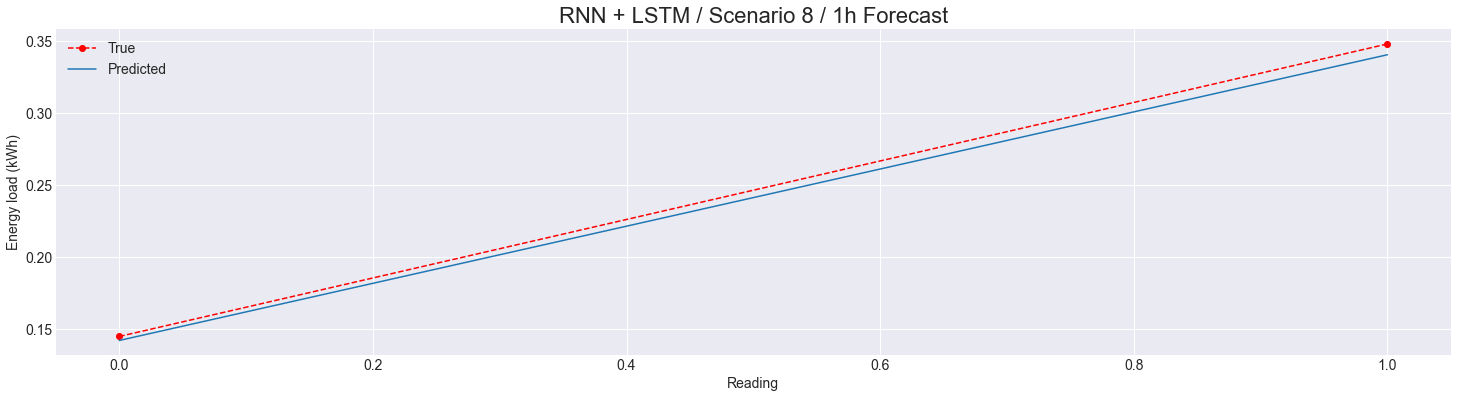

In [82]:
matplotlib.rcParams.update({'font.size': 14})
predicted_denselstm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_denselstm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_denselstm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RNN + LSTM / Scenario 8 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario8/1_allHouseholds/S8_1h_RNN_LSTM.jpeg', dpi = 500)
plt.show()

This is the best model, the predictions accurately follow the observed energy consumption.

### Best model

In [83]:
models_performances = pd.DataFrame([R2_scores,MSE_scores,RMSE_scores,MAE_scores,MAPE_scores,train_times],
                                   columns=models_predictions, 
                                   index=['R2_scores', 'MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores', 'Train_Time'])
models_performances

,MLR,SVM,RF,FFNNs,LSTM,RNN,Dense+LSTM
R2_scores,1.000000e+00,0.999881,0.970427,0.974636,0.996812,0.707376,0.996764
MSE_scores,5.440629e-17,0.000001,0.000247,0.000242,0.000034,0.002811,0.000032
RMSE_scores,7.376062e-09,0.001103,0.015726,0.015548,0.005831,0.053020,0.005640
MAE_scores,6.659410e-09,0.000949,0.012095,0.015059,0.005553,0.052905,0.005127
MAPE_scores,2.615211e-06,0.571130,6.916695,7.056379,2.299602,35.521139,2.074246
Train_Time,4.786992e-02,0.241354,23.856606,49.976974,63.080927,43.103489,39.511466


In [84]:
models_performances.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/BestModel_Scenario4_1h.csv', index=False)

**Plotting all models together.**

In [85]:
prev_day = train_y[-2:] #energy readings from previous day
y_plotting = np.concatenate([prev_day, test_y], axis=0)

In [86]:

# Get all predictions from the models
predicted_energy=[predicted_mreg['predicted'],
                  predicted_svm['predicted'],
                  predicted_rf['predicted'],
                  predicted_fnn['predicted'],
                  predicted_lstm['predicted'],
                  predicted_rnn['predicted'],
                  predicted_denselstm['predicted']]

In [87]:
prev_2days = sorted(pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario4.csv').time)[-4:]

In [88]:
prev_2days

['2014-02-27 22:30:00',
 '2014-02-27 23:00:00',
 '2014-02-27 23:30:00',
 '2014-02-28 00:00:00']

In [89]:
df_for_plotting = pd.DataFrame(y_plotting, index=prev_2days, columns=['Original'])

In [90]:
# Initialize all columns with null values
df_for_plotting["Train"] = np.nan
# Add a column for each model's predictions
col_names=['MLR', 'SVR', 'RF', 'FFNN', 'LSTM', 'RNN', 'Dense-LSTM']
for col_name in col_names:
  df_for_plotting[col_name+' forecast'] = np.nan

In [91]:
# Fill in with corresponding values
df_for_plotting["Train"][:-2] = prev_day

for i, model_pred in enumerate(predicted_energy):
  df_for_plotting[col_names[i]+' forecast'][-2:] = model_pred

In [92]:
# Turn index to datetime
df_for_plotting.index = pd.to_datetime(df_for_plotting.index)

In [93]:
df_for_plotting.columns

Index(['Original', 'Train', 'MLR forecast', 'SVR forecast', 'RF forecast',
       'FFNN forecast', 'LSTM forecast', 'RNN forecast',
       'Dense-LSTM forecast'],
      dtype='object')

In [94]:
import datetime
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

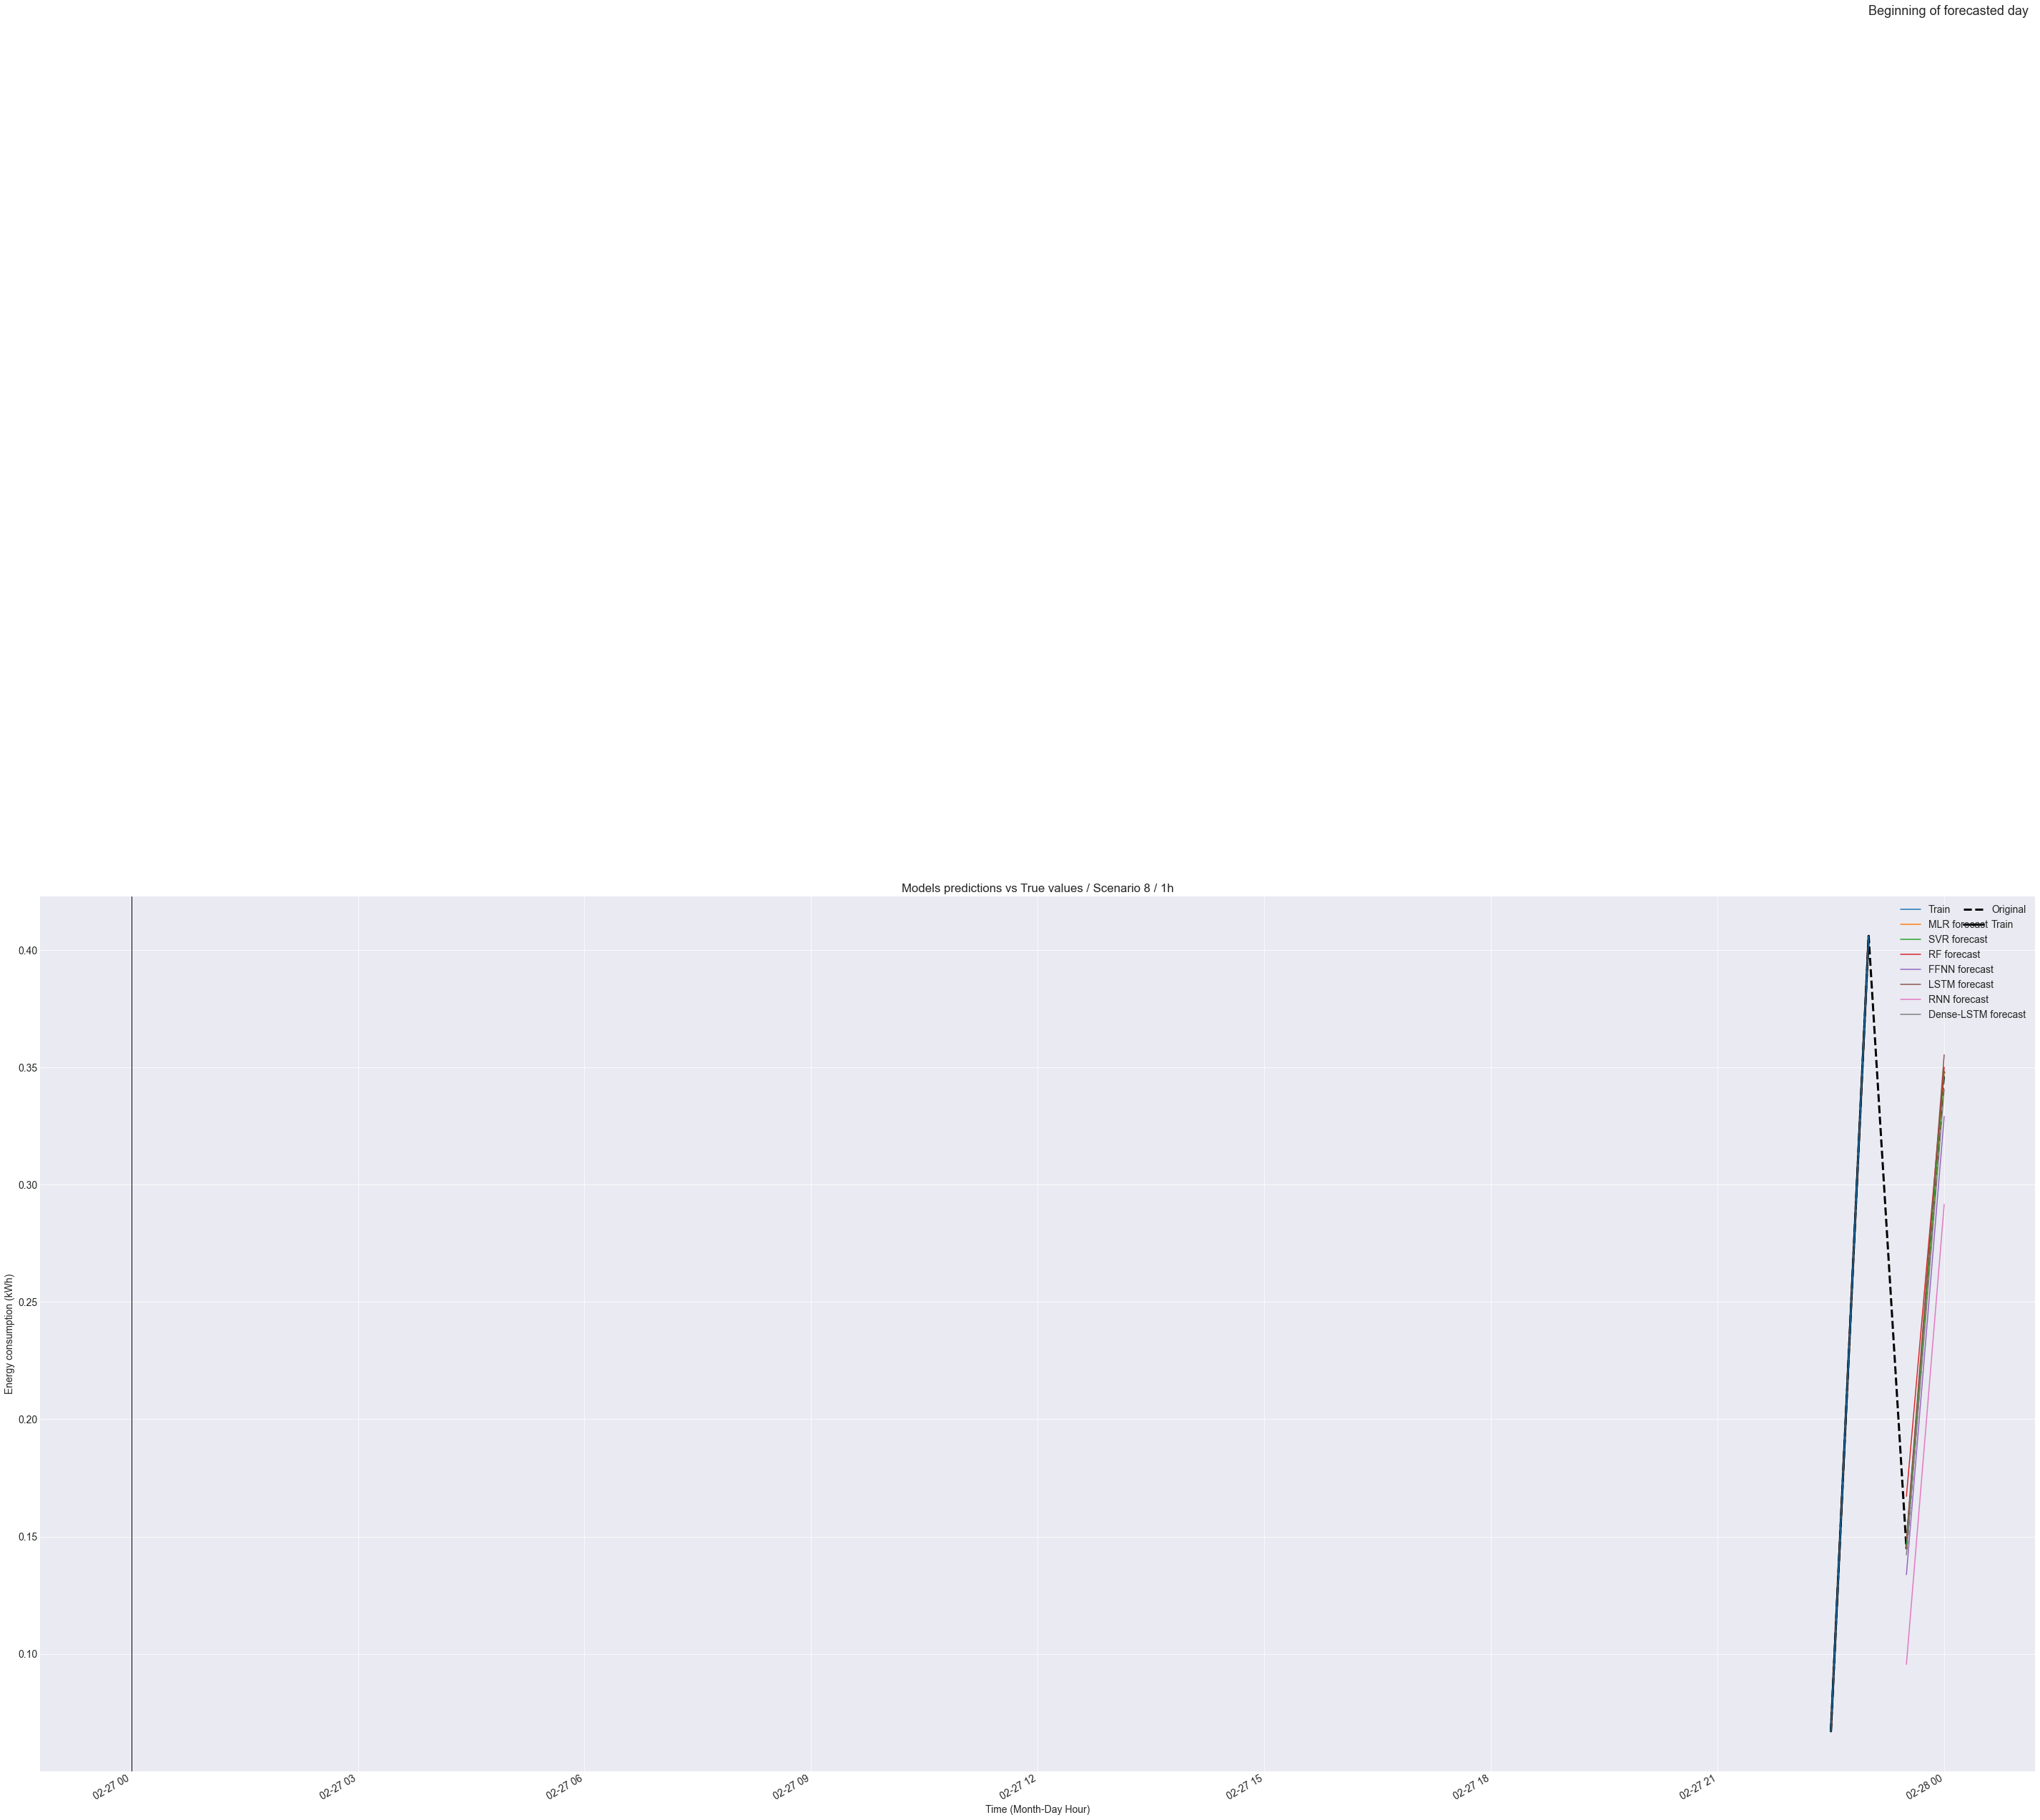

In [95]:
import matplotlib.dates as md

fig = plt.figure(figsize=(50,25))
ax = fig.add_subplot(111)


# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='K', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[1:]:
  df_for_plotting[forecast].plot(label=forecast)

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 23:00:00')
plt.text(label_x_pos, 0.8, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)


# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.8, dx, 0.05, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)


plt.title('Models predictions vs True values / Scenario 8 / 1h')

plt.legend()
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario8/1_allHouseholds/S8_1h_OriginalPredicted_All.jpeg', dpi = 500)
plt.show()

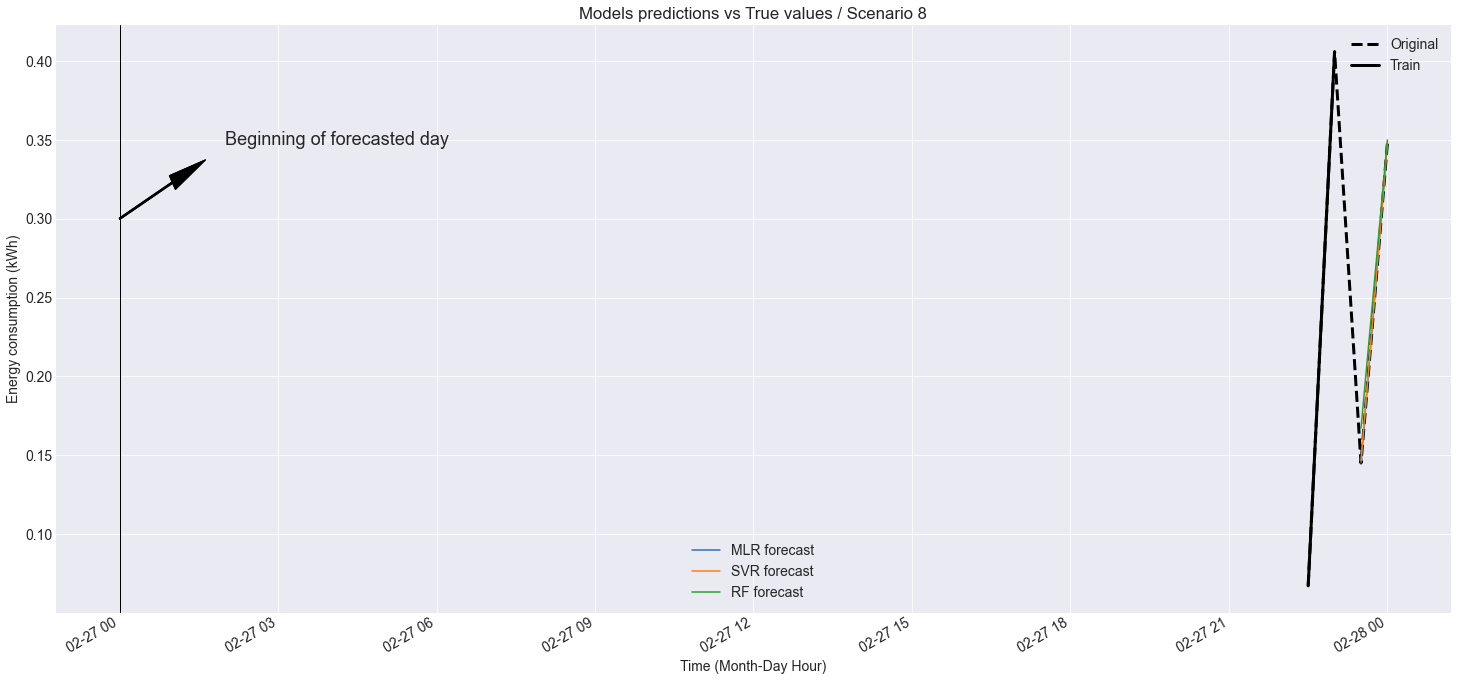

In [96]:
import matplotlib.dates as md

fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='k', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[2:5]:
  df_for_plotting[forecast].plot(label=forecast)

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00')
plt.text(label_x_pos, 0.35, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)

# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.3, dx, 0.023, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)

plt.title('Models predictions vs True values / Scenario 8')

plt.legend()
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario8/1_allHouseholds/S8_1h_RegressionModelsPredicted_All.jpeg', dpi = 500)
plt.show()

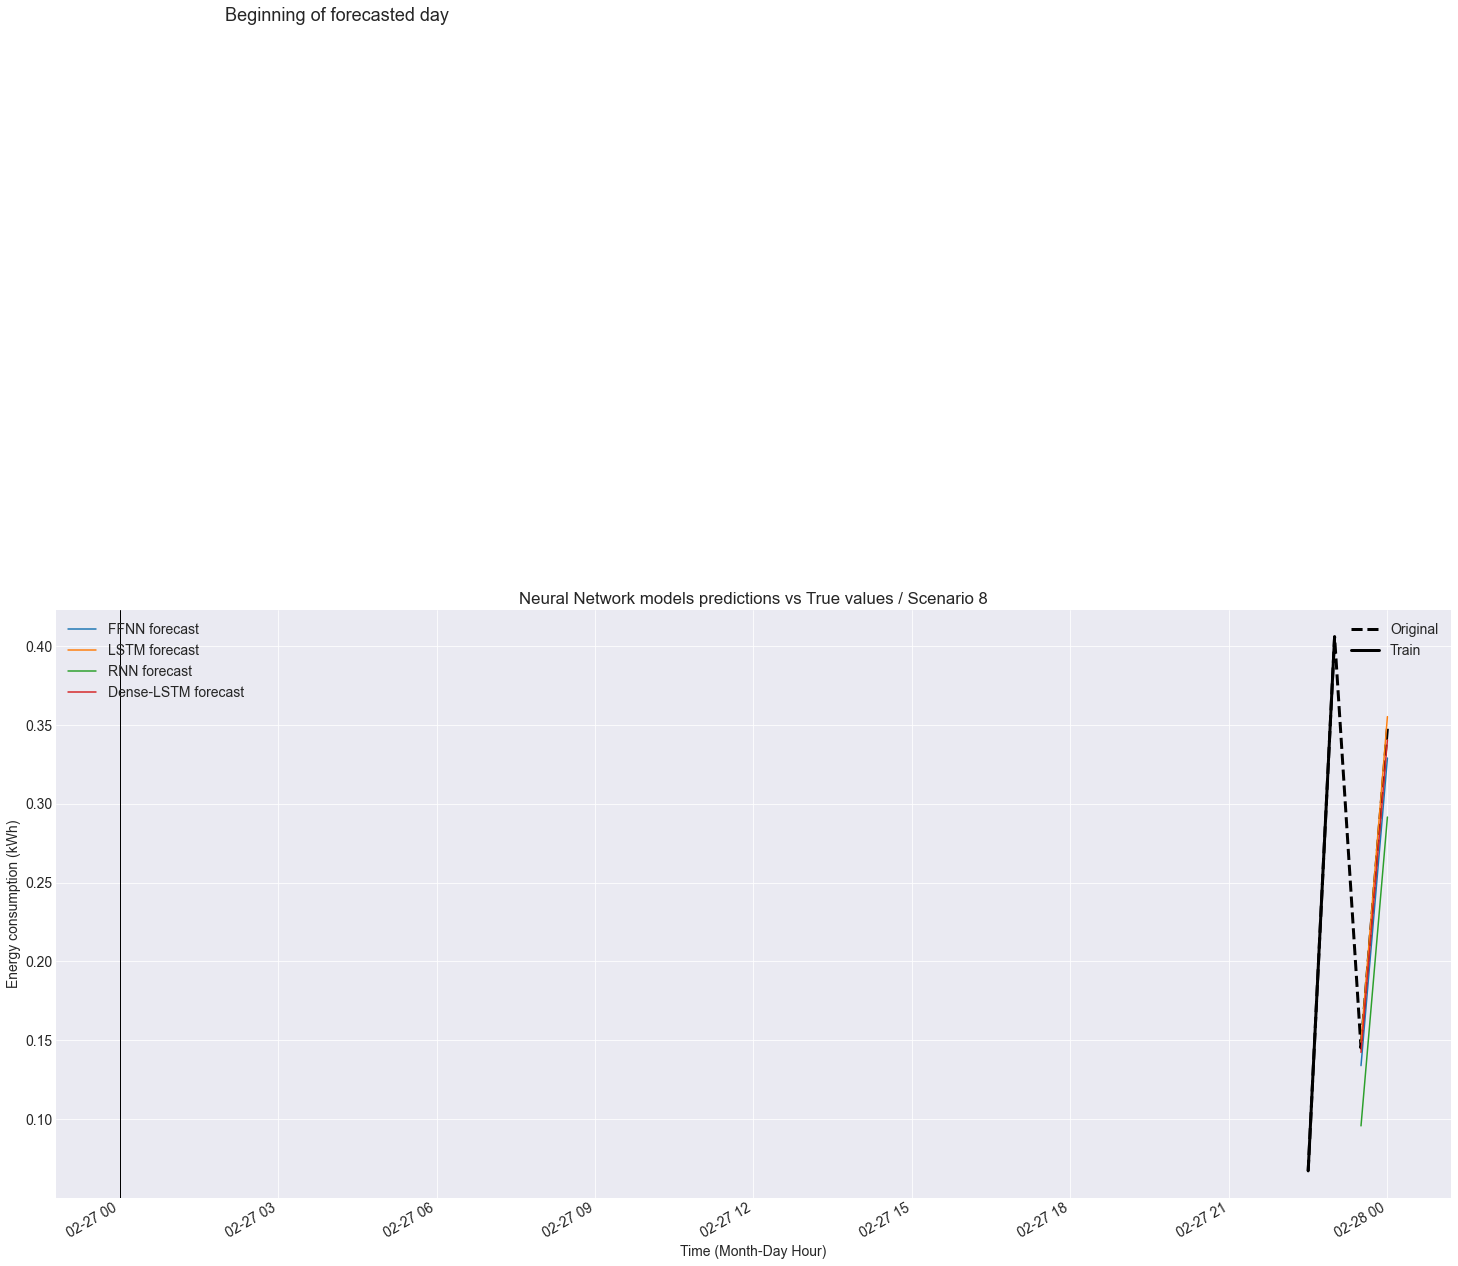

In [97]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='k', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[5:]:
  df_for_plotting[forecast].plot()

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00')
plt.text(label_x_pos, 0.8, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)

# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.75, dx, 0.023, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)

plt.title('Neural Network models predictions vs True values / Scenario 8')
plt.legend(loc='upper left')
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario8/1_allHouseholds/S8_1h_OriginalPredicted_4_8.jpeg', dpi = 500)
plt.show()

## House level prediction 
-For each half hour, for each of the 33 types.

In [98]:
houses_data = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/all_houses_Scenario4.csv')

In [99]:
houses_data

,LCLid,tstp,energy(kWh/hh)
0,2,2012-10-12 00:30:00,0.000
1,2,2012-10-12 01:00:00,0.000
2,2,2012-10-12 01:30:00,0.000
3,2,2012-10-12 02:00:00,0.000
4,2,2012-10-12 02:30:00,0.000
...,...,...,...
8092712,5124,2014-02-27 22:00:00,0.673
8092713,5124,2014-02-27 22:30:00,0.590
8092714,5124,2014-02-27 23:00:00,0.552
8092715,5124,2014-02-27 23:30:00,0.519


In [100]:
houses_data.rename(columns={'tstp':'time'}, inplace=True)

Merging with the weather_energy data

In [101]:
weather_energy = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario4.csv')

In [102]:
weather_energy.columns[1:]

Index(['year', 'month', 'day', 'hour', 'weekday', 'energy(kWh/hh)',
       'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity', 'holiday_ind',
       'stdorToU', 'Acorn', 'Acorn_grouped', 'weekend'],
      dtype='object')

In [103]:
updated_houses = houses_data.merge(weather_energy, on='time')

In [104]:
updated_houses.columns

Index(['LCLid', 'time', 'energy(kWh/hh)_x', 'year', 'month', 'day', 'hour',
       'weekday', 'energy(kWh/hh)_y', 'visibility', 'windBearing',
       'temperature', 'dewPoint', 'pressure', 'apparentTemperature',
       'windSpeed', 'humidity', 'holiday_ind', 'stdorToU', 'Acorn',
       'Acorn_grouped', 'weekend'],
      dtype='object')

In [105]:
updated_houses.columns = ['LCLid', 'time', 'energy(kWh/hh)_x', 'year', 'month', 'day', 'hour',
       'weekday', 'energy(kWh/hh)_y', 'visibility', 'windBearing',
       'temperature', 'dewPoint', 'pressure', 'apparentTemperature',
       'windSpeed', 'humidity', 'holiday_ind', 'stdorToU', 'Acorn',
       'Acorn_grouped', 'weekend']

In [106]:
updated_houses

,LCLid,time,energy(kWh/hh)_x,year,month,day,hour,weekday,energy(kWh/hh)_y,visibility,...,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday_ind,stdorToU,Acorn,Acorn_grouped,weekend
0,2,2012-10-12 00:30:00,0.000,2012,10,12,0,4,0.135,11.76,...,12.21,999.47,13.61,5.40,0.91,0,0,10,4,0
1,246,2012-10-12 00:30:00,0.975,2012,10,12,0,4,0.135,11.76,...,12.21,999.47,13.61,5.40,0.91,0,0,10,4,0
2,1074,2012-10-12 00:30:00,1.438,2012,10,12,0,4,0.135,11.76,...,12.21,999.47,13.61,5.40,0.91,0,0,10,4,0
3,3281,2012-10-12 00:30:00,0.078,2012,10,12,0,4,0.135,11.76,...,12.21,999.47,13.61,5.40,0.91,0,0,10,4,0
4,3305,2012-10-12 00:30:00,0.101,2012,10,12,0,4,0.135,11.76,...,12.21,999.47,13.61,5.40,0.91,0,0,10,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8086036,183,2011-12-03 06:30:00,0.109,2011,12,3,6,5,0.109,11.73,...,10.26,1001.07,11.00,6.37,0.95,0,0,7,4,1
8086037,183,2011-12-03 07:00:00,0.030,2011,12,3,7,5,0.030,11.93,...,9.73,1001.07,10.96,5.48,0.92,0,0,7,4,1
8086038,183,2011-12-03 07:30:00,0.082,2011,12,3,7,5,0.082,11.93,...,9.73,1001.07,10.96,5.48,0.92,0,0,7,4,1
8086039,183,2011-12-03 08:00:00,0.030,2011,12,3,8,5,0.030,13.71,...,9.11,1001.55,11.01,6.32,0.88,0,0,7,4,1


In [107]:
updated_houses.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/updated_houses_S4.csv')

In [108]:
updated_houses = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/updated_houses_S4.csv')

In [109]:
updated_houses.columns

Index(['Unnamed: 0', 'LCLid', 'time', 'energy(kWh/hh)_x', 'year', 'month',
       'day', 'hour', 'weekday', 'energy(kWh/hh)_y', 'visibility',
       'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity', 'holiday_ind',
       'stdorToU', 'Acorn', 'Acorn_grouped', 'weekend'],
      dtype='object')

In [110]:
updated_houses.columns = ['Unnamed: 0', 'LCLid', 'time', 'energy(kWh/hh)', 'year', 'month',
       'day', 'hour', 'weekday', 'energy(kWh/hh)_y', 'visibility',
       'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity', 'holiday_ind',
       'stdorToU', 'Acorn', 'Acorn_grouped', 'weekend']

In [111]:
updated_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8086041 entries, 0 to 8086040
Data columns (total 23 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Unnamed: 0           int64  
 1   LCLid                int64  
 2   time                 object 
 3   energy(kWh/hh)       float64
 4   year                 int64  
 5   month                int64  
 6   day                  int64  
 7   hour                 int64  
 8   weekday              int64  
 9   energy(kWh/hh)_y     float64
 10  visibility           float64
 11  windBearing          int64  
 12  temperature          float64
 13  dewPoint             float64
 14  pressure             float64
 15  apparentTemperature  float64
 16  windSpeed            float64
 17  humidity             float64
 18  holiday_ind          int64  
 19  stdorToU             int64  
 20  Acorn                int64  
 21  Acorn_grouped        int64  
 22  weekend              int64  
dtypes: float64(9), int64(13), object

In [112]:
MSE_scores_HH = []
RMSE_scores_HH = []
MAE_scores_HH = []
MAPE_scores_HH = []
households_predictions = ['HH_1',
                      'HH_2',
                      'HH_3',
                      'HH_4',
                      'HH_5',
                      'HH_6',
                      'HH_7',
                      'HH_8',
                      'HH_9',
                      'HH_10',
                      'HH_11',
                      'HH_12',
                      'HH_13',
                      'HH_14',
                      'HH_15',
                      'HH_16',
                      'HH_17',
                      'HH_18',
                      'HH_19',
                      'HH_20',
                      'HH_21',
                      'HH_22',
                      'HH_23',
                      'HH_24',
                      'HH_25',
                      'HH_26',
                      'HH_27',
                      'HH_28', 
                      'HH_29']

Function to check another household:

In [113]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from keras.optimizers import Adam

In [114]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [115]:
# tune the Rf parametersbegining with house numbber of your choice 
def predict_household_AfterTuning(num):
  house = updated_houses[updated_houses.LCLid==num]

  np.random.seed(5)
  dataframe = house.loc[:,'energy(kWh/hh)']
  dataset = dataframe.values
  dataset = dataset.astype('float32')

  reframed = series_to_supervised(dataset, 24,1)

  # Select required columns and merge with supervised data
  df=house[weather_energy.columns[1:]]
  df = df[12:]
  reframed = pd.concat([df, reframed], axis=1).dropna()

  reframed = reframed.reindex(reframed.columns, axis=1)
  reframed = reframed.values

  # split into train and test sets''''
  train = reframed[:(len(reframed)-2), :]
  test = reframed[(len(reframed)-2):len(reframed), :]

  #test_X, labels = test[:, :-1], test[:, -1]
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  
  # Tranform the test set
  #train_X = scaler.fit_transform(train_X)
  #test_X = scaler.transform(test_X)

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


  model = Sequential()
  model.add(LSTM(128,  activation='softplus', input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))

  optimizer = Adam(lr=0.001)

  model.compile(loss='mean_squared_error', # Mean squared error
              optimizer = optimizer # Optimization algorithm
              )


  predicted = model.predict(test_X)

  mse_HH = mean_squared_error(predicted,test_y.ravel())
  rmse_HH = mean_squared_error(predicted,test_y.ravel(), squared=False)
  mae_HH = mean_absolute_error(predicted,test_y.ravel())
  mape_HH = mean_absolute_percentage_error(predicted, test_y.ravel())

  print(f'Mse:  {mse_HH:.15f}')
  print(f'Rmse: {rmse_HH:.15f}')
  print(f'Mae:  {mae_HH:.15f}')
  print(f'Mape:  {mape_HH:.15f}')
  #print(f'Training time: {train_time_HH:.3f} s') 

  MSE_scores_HH.append(mse_HH)
  RMSE_scores_HH.append(rmse_HH)
  MAE_scores_HH.append(mae_HH)
  MAPE_scores_HH.append(mape_HH)
#  train_times_HH.append(train_time)

  matplotlib.rcParams.update({'font.size': 16})
  predicted_house = pd.DataFrame({'Predicted':predicted.ravel(),'True Reading':test_y.ravel()})
  predicted_house['True Reading'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
  predicted_house['Predicted'].plot()
  plt.title(f'House {num} Prediction /LSMT (Scenario 8)')
  plt.xlabel('Reading')
  plt.ylabel('Energy (kWh)')
  # style

  plt.style.use('seaborn-darkgrid')
  palette = plt.get_cmap('Set1')

  plt.grid(b=True, which='major', color='w', linewidth=1.0)
  plt.legend(['True','Predicted'])
  plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario8/2_singleHouseholdLevel/best_NN_model/S8_1h_RNN_HH'+str(num) + '.jpeg', dpi = 500)
  plt.show()


Mse:  152.061524283887195
Rmse: 12.331322892694327
Mae:  12.329871859401464
Mape:  101.020212928060204


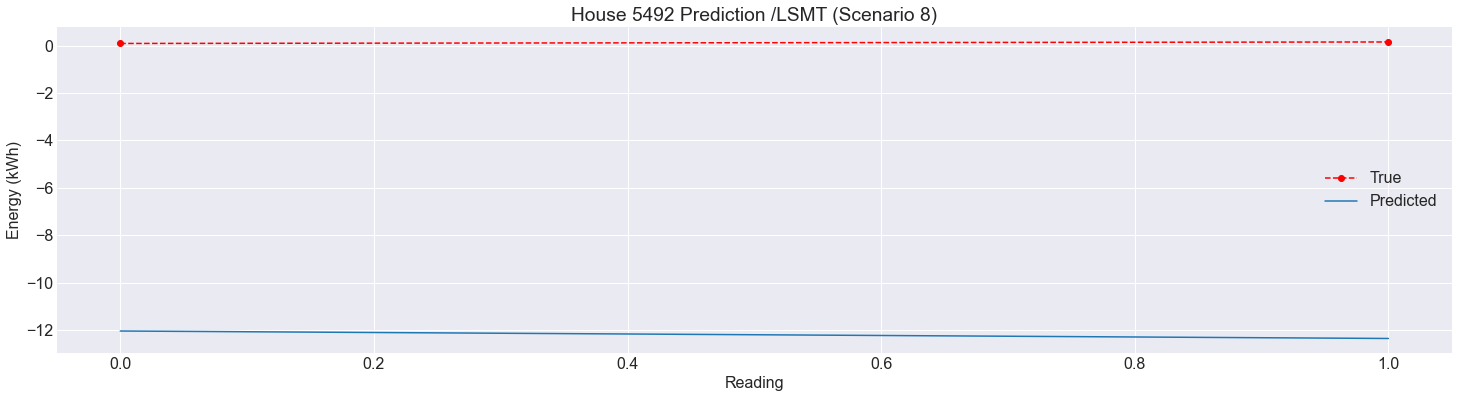

Mse:  25.780647064048793
Rmse: 5.077464629522178
Mae:  5.053393628448248
Mape:  103.191576836832638


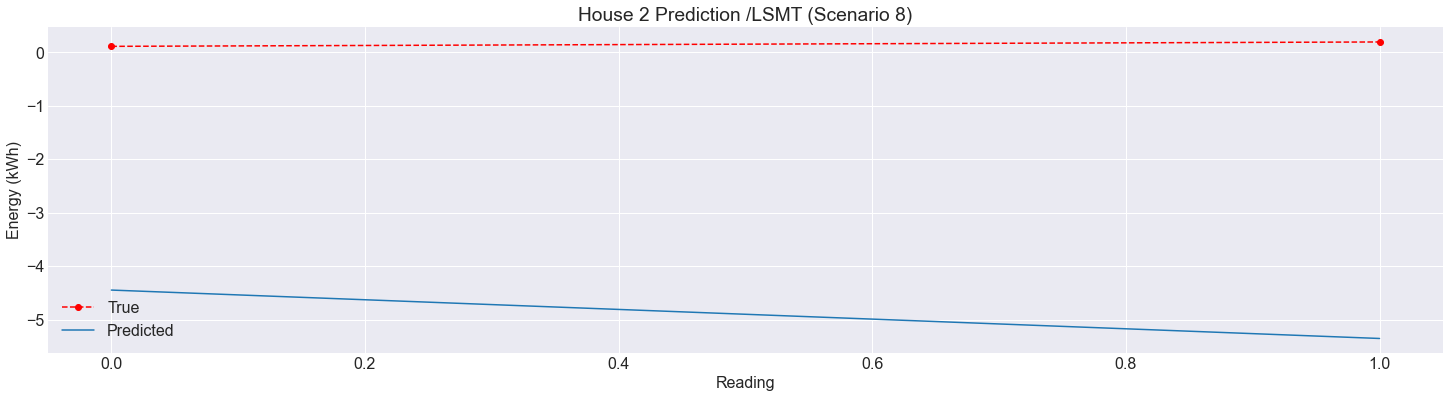

Mse:  1296.146831553123775
Rmse: 36.002039269368112
Mae:  35.990118786692619
Mape:  99.095002692542153


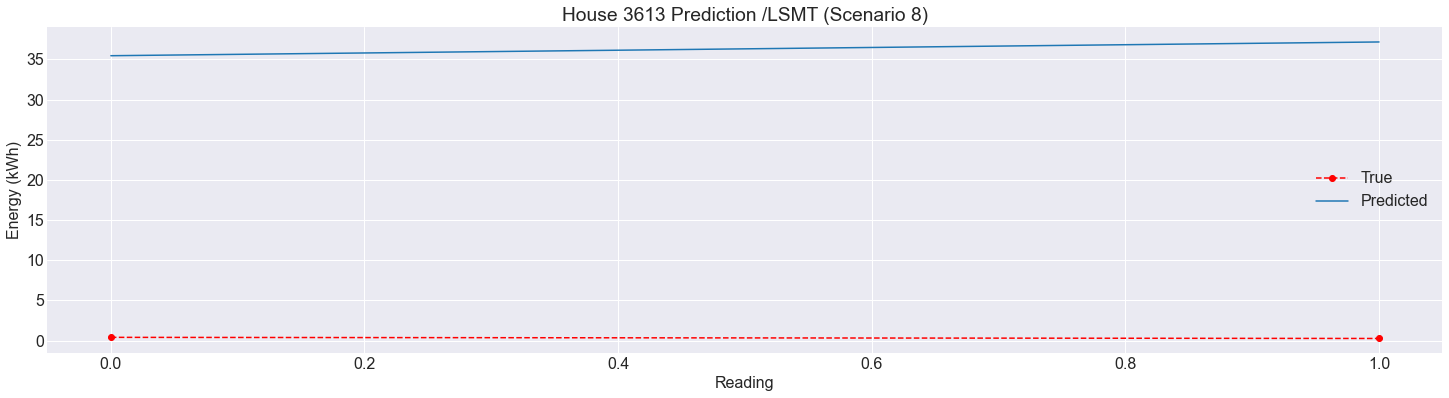

Mse:  1539.100439180582498
Rmse: 39.231370600331850
Mae:  39.231356084346771
Mape:  99.605194757272074


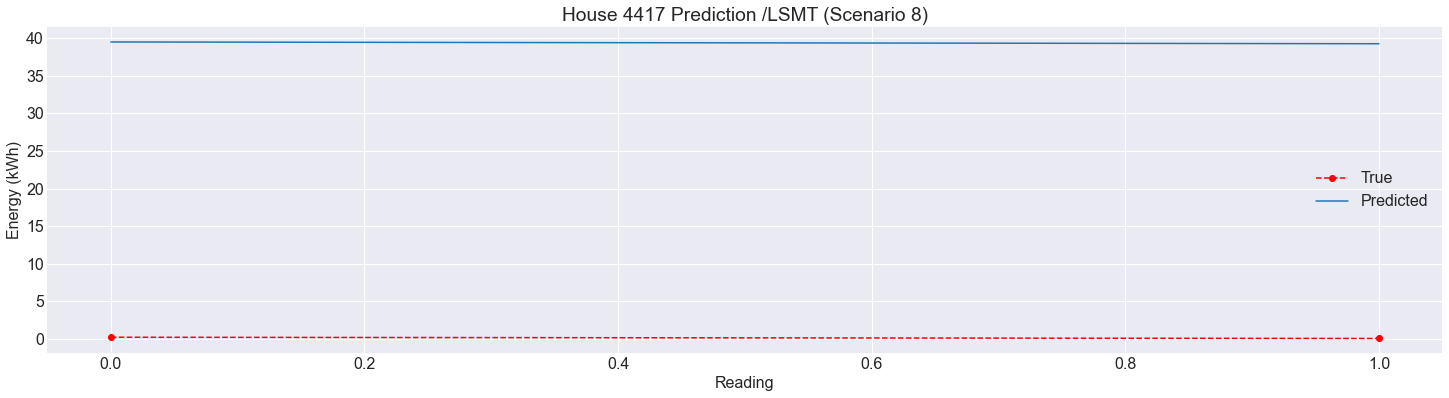

Mse:  7732.813608608891627
Rmse: 87.936417988276574
Mae:  87.936366302892566
Mape:  99.951124831407185


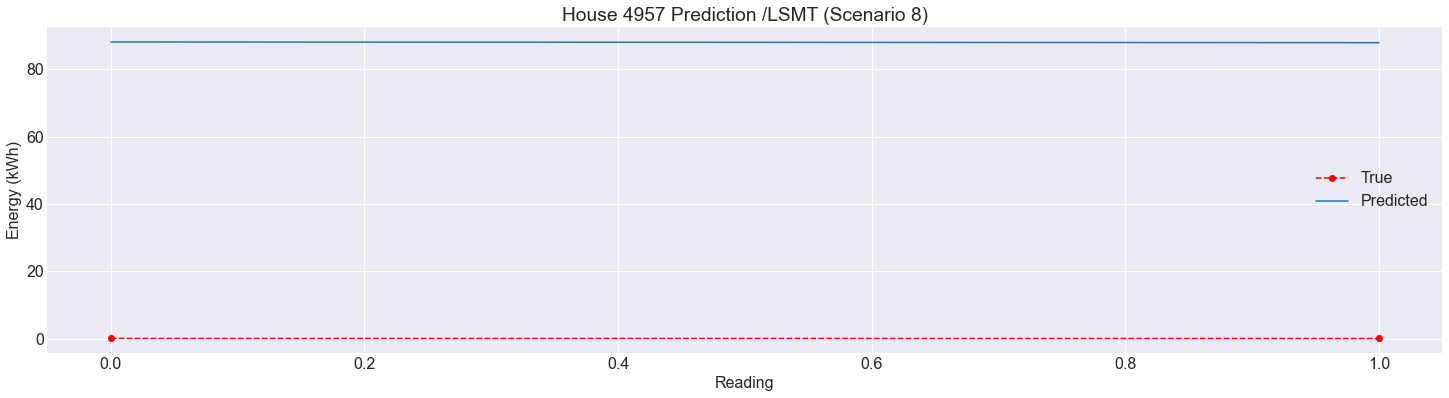

Mse:  648.954514394508124
Rmse: 25.474585656974053
Mae:  25.471369098871946
Mape:  100.406142842051381


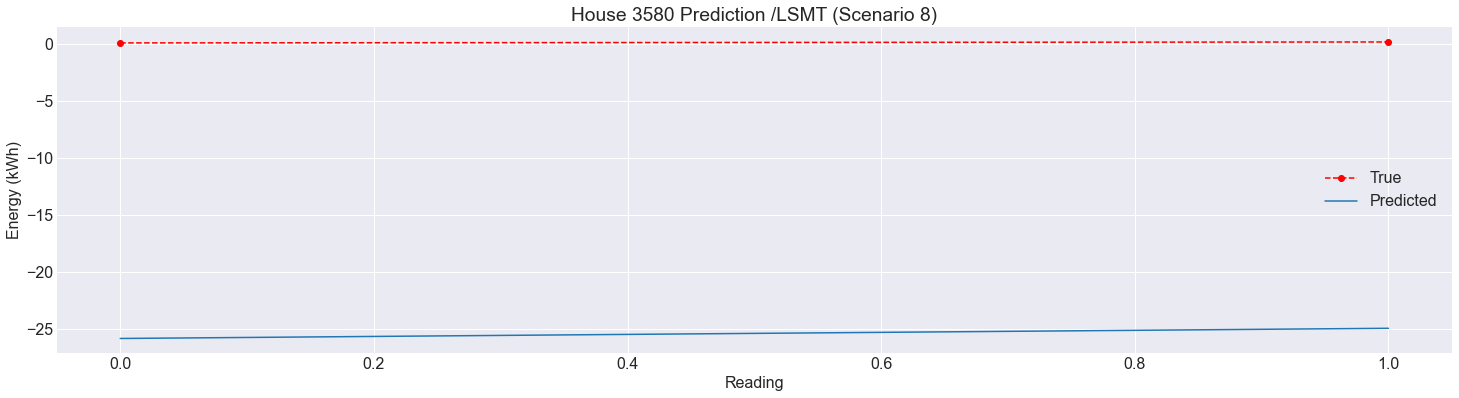

Mse:  5441.842522721386558
Rmse: 73.768845203929999
Mae:  73.768675323575735
Mape:  100.147298443828220


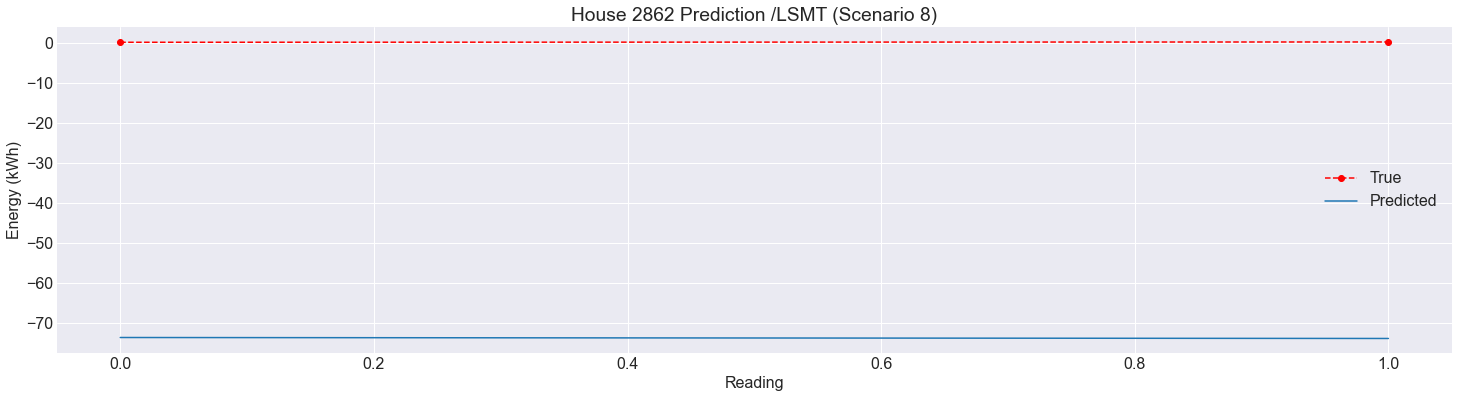

Mse:  2777.799717558375050
Rmse: 52.704835808096156
Mae:  52.704683274030685
Mape:  99.868306336446878


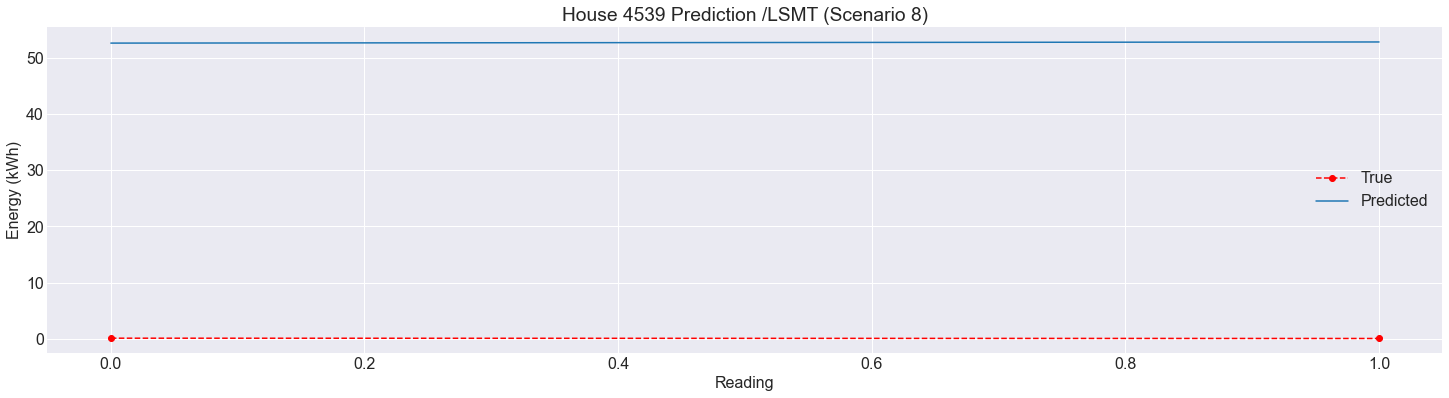

Mse:  15955.160936827285695
Rmse: 126.313740095158636
Mae:  126.313640133477747
Mape:  100.164543936135701


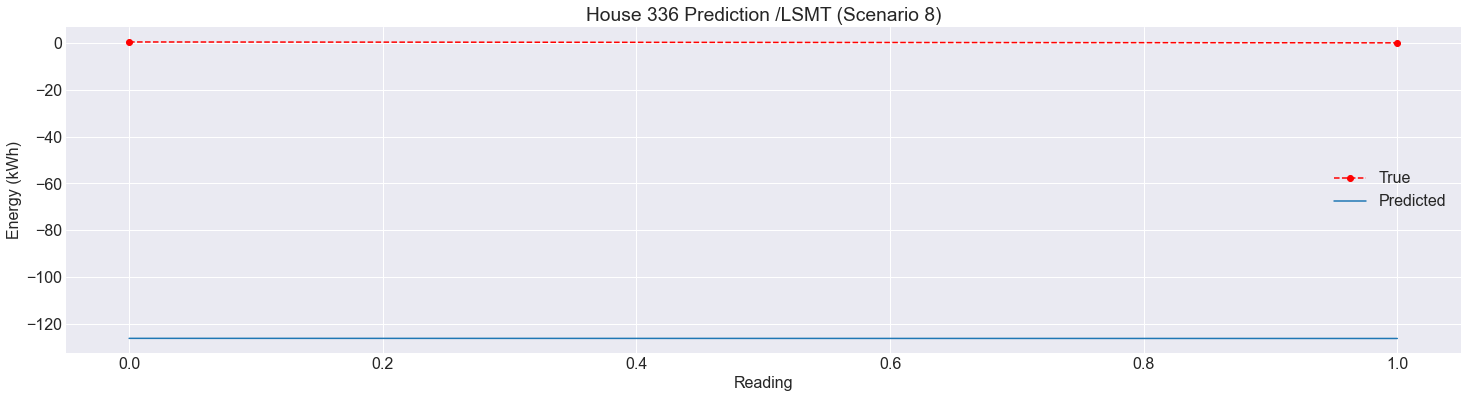

Mse:  9173.126947933256815
Rmse: 95.776442552087190
Mae:  95.775188535451889
Mape:  100.283761704632198


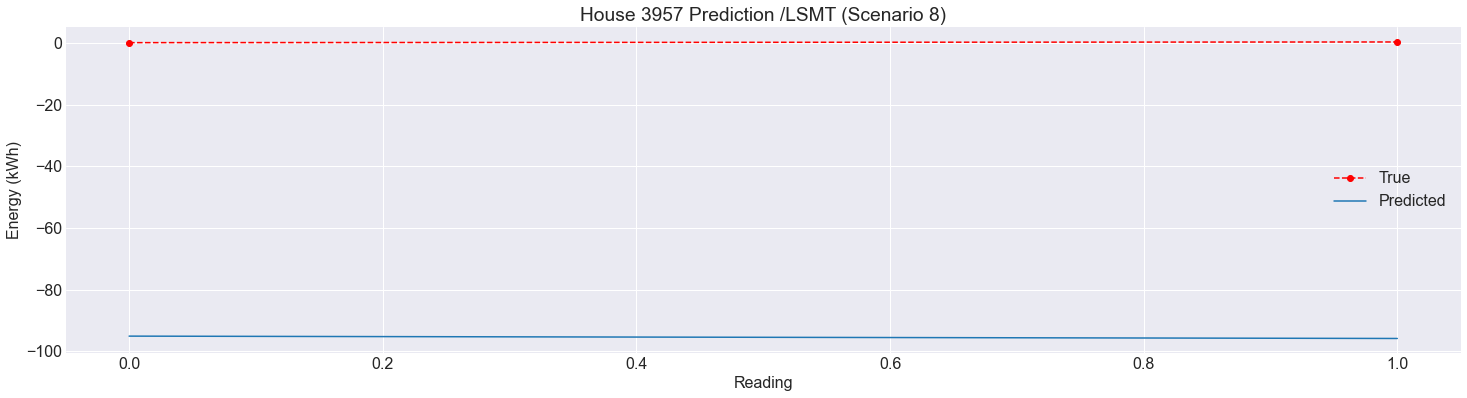

Mse:  9979.118231288506649
Rmse: 99.895536593425973
Mae:  99.893837831914425
Mape:  99.883507479427749


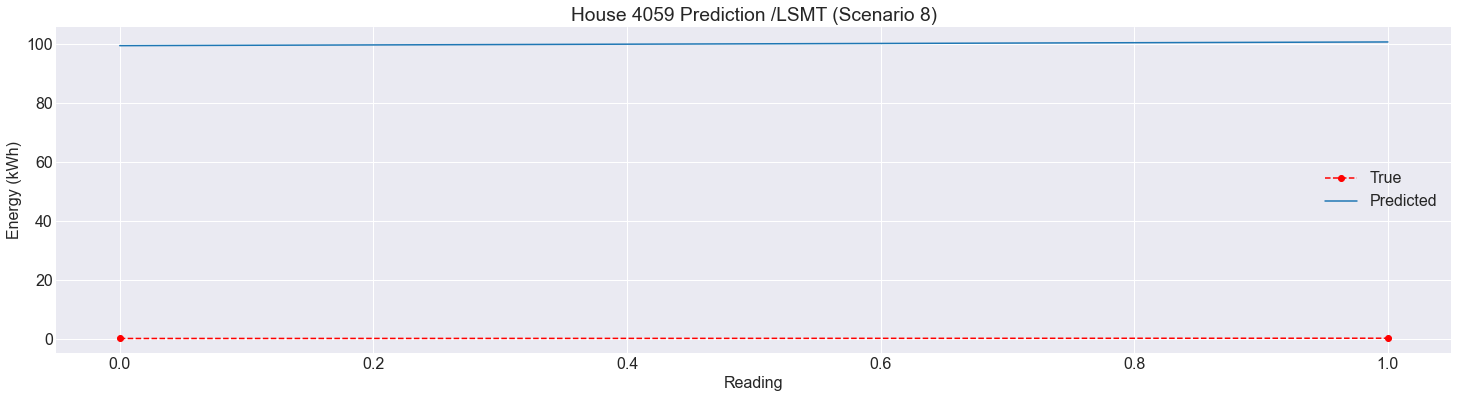

Mse:  14536.885281321812727
Rmse: 120.569006304778895
Mae:  120.569003296084702
Mape:  100.010368582773964


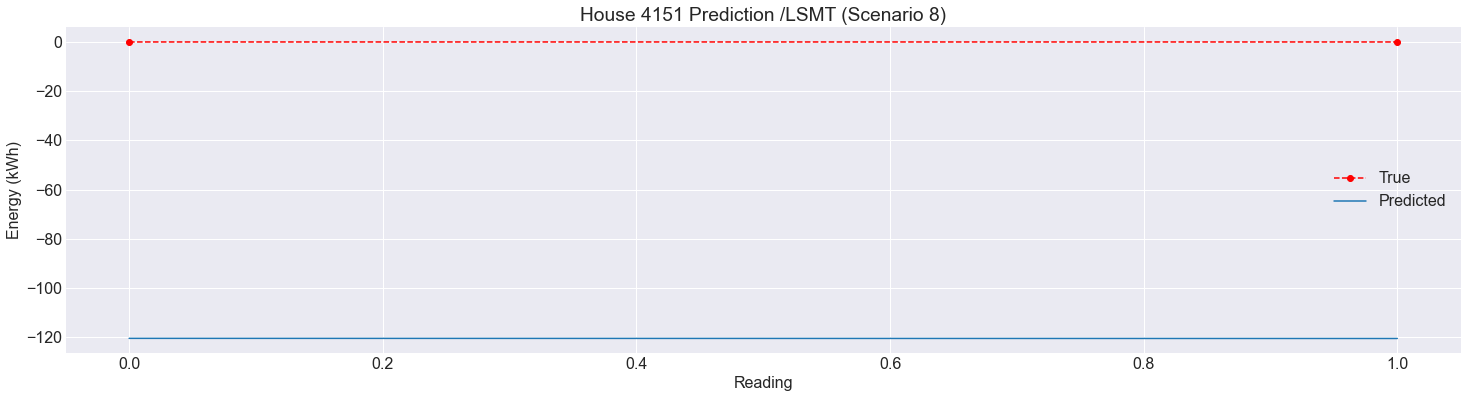

Mse:  1575.444109400720663
Rmse: 39.691864524115275
Mae:  39.677017763257027
Mape:  100.477726024906744


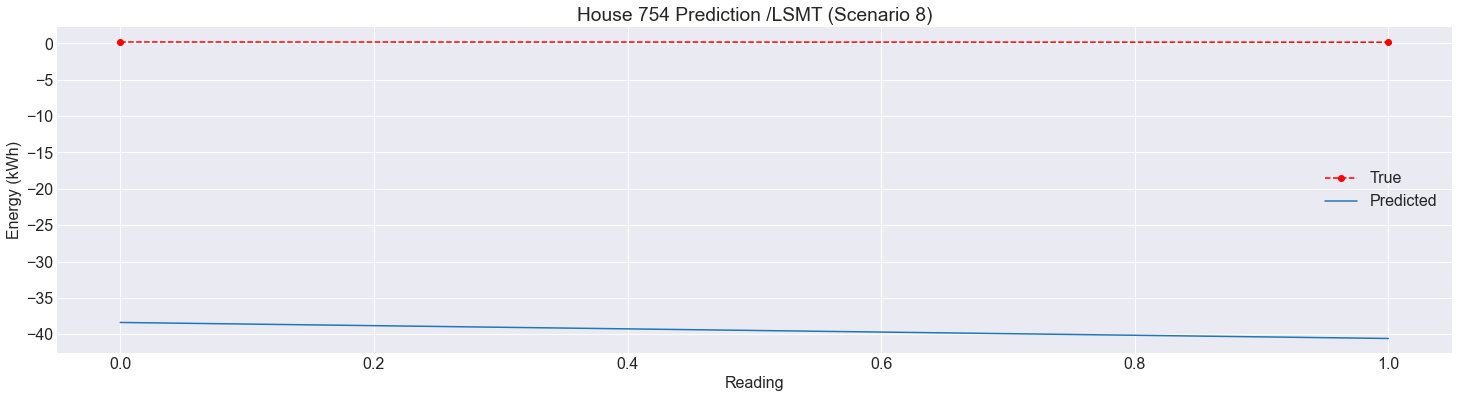

Mse:  382.406598191158253
Rmse: 19.555219205909154
Mae:  19.554392430931330
Mape:  99.072823619057175


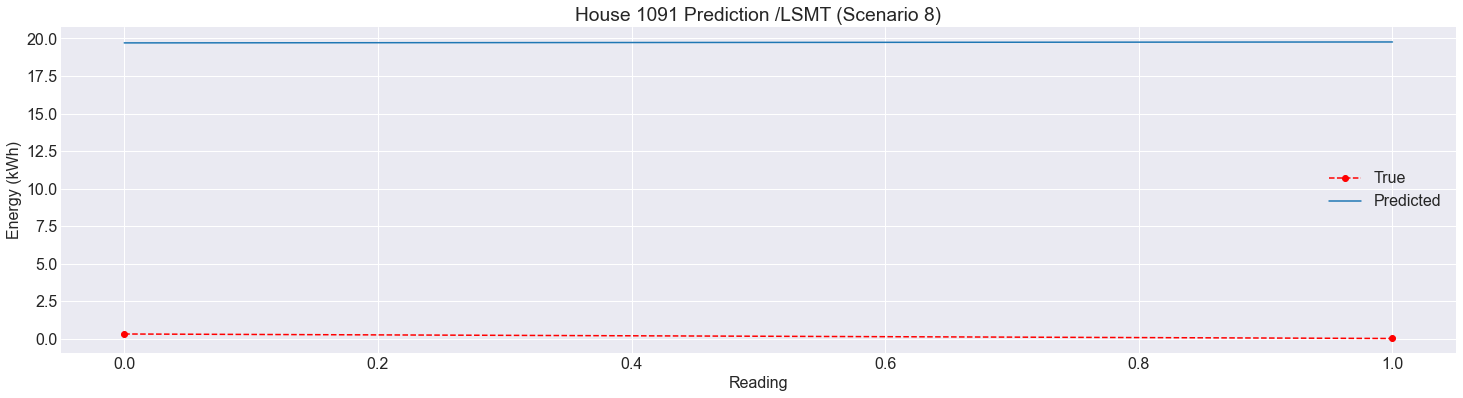

Mse:  4790.298567650373116
Rmse: 69.211982832818578
Mae:  69.211943724192679
Mape:  100.078082152861512


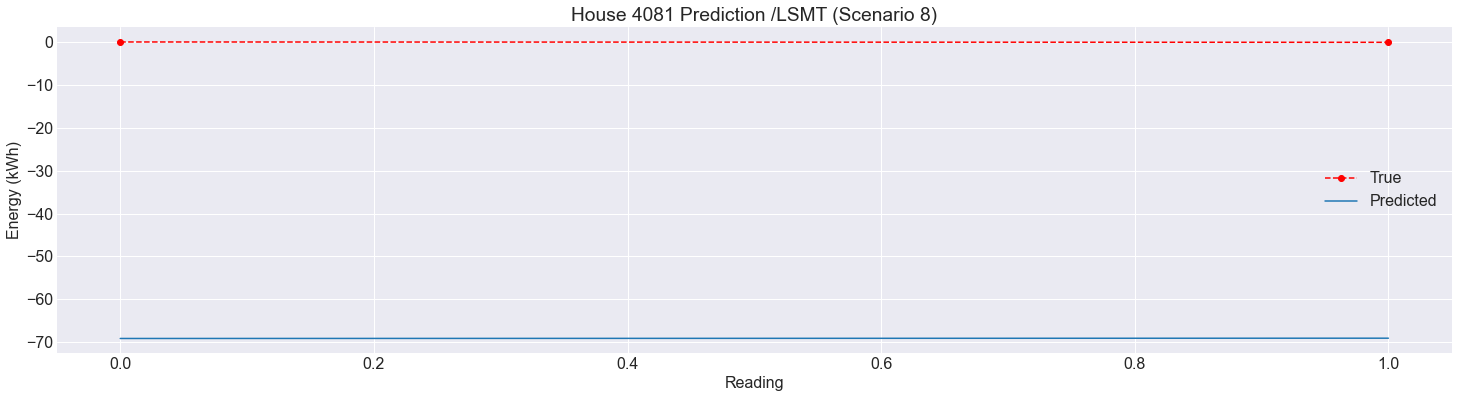

Mse:  741.429350877949673
Rmse: 27.229200334896905
Mae:  27.228299628943205
Mape:  100.182138222453275


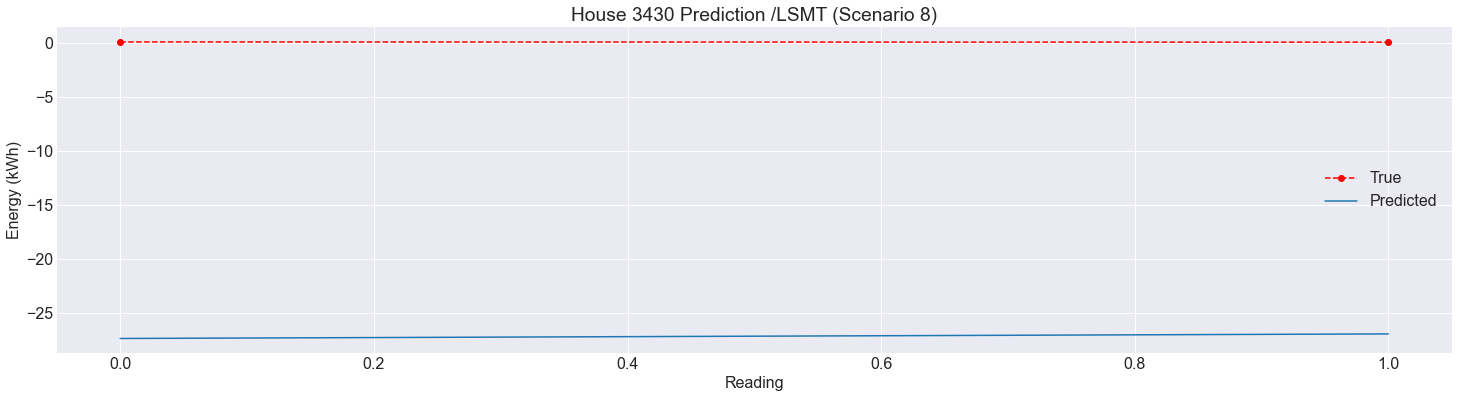

Mse:  201.658092103933825
Rmse: 14.200637031624103
Mae:  14.200632639229298
Mape:  99.338935180475517


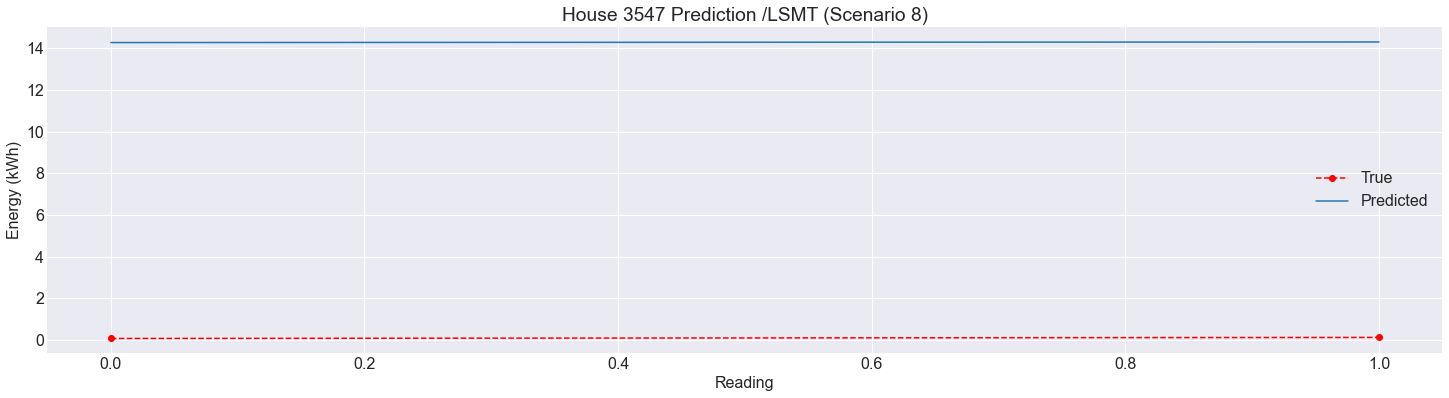

Mse:  7656.208874249214205
Rmse: 87.499764995394216
Mae:  87.499764095991850
Mape:  100.231966617392402


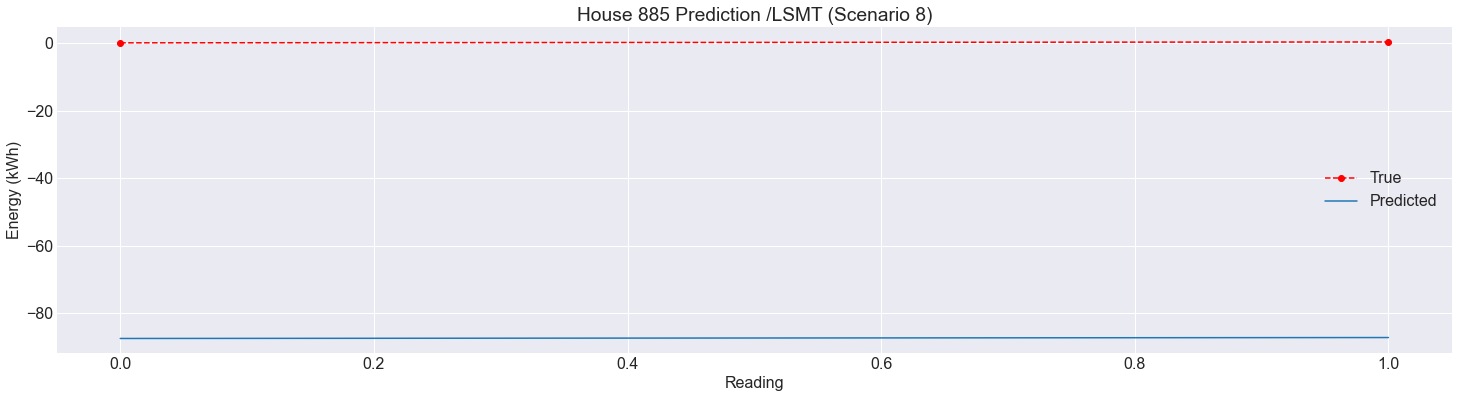

Mse:  2978.613351833412707
Rmse: 54.576674063499077
Mae:  54.576667923480272
Mape:  99.828974369154395


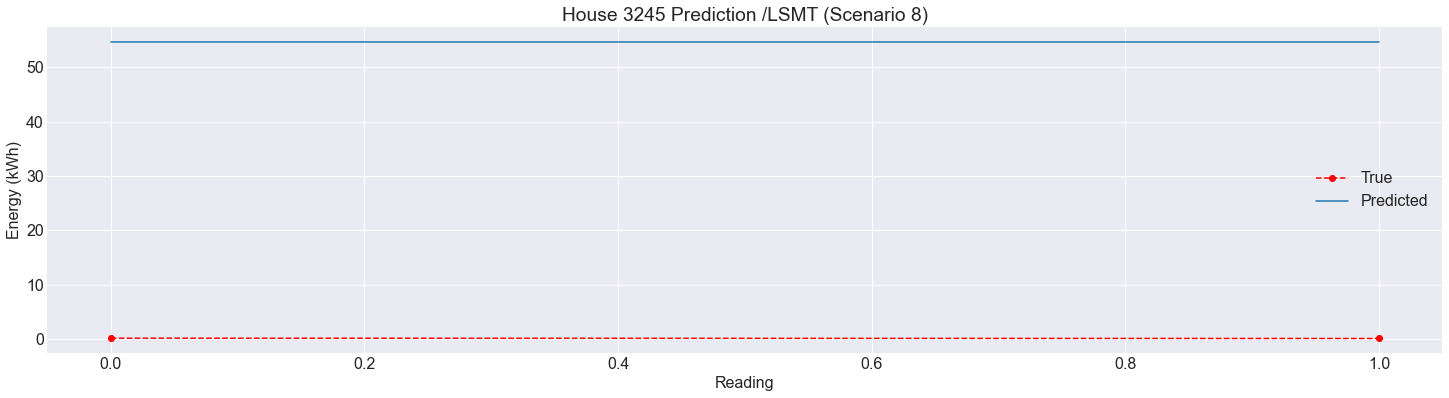

Mse:  2635.890478543965401
Rmse: 51.340924013344029
Mae:  51.340907402336597
Mape:  100.446071732039101


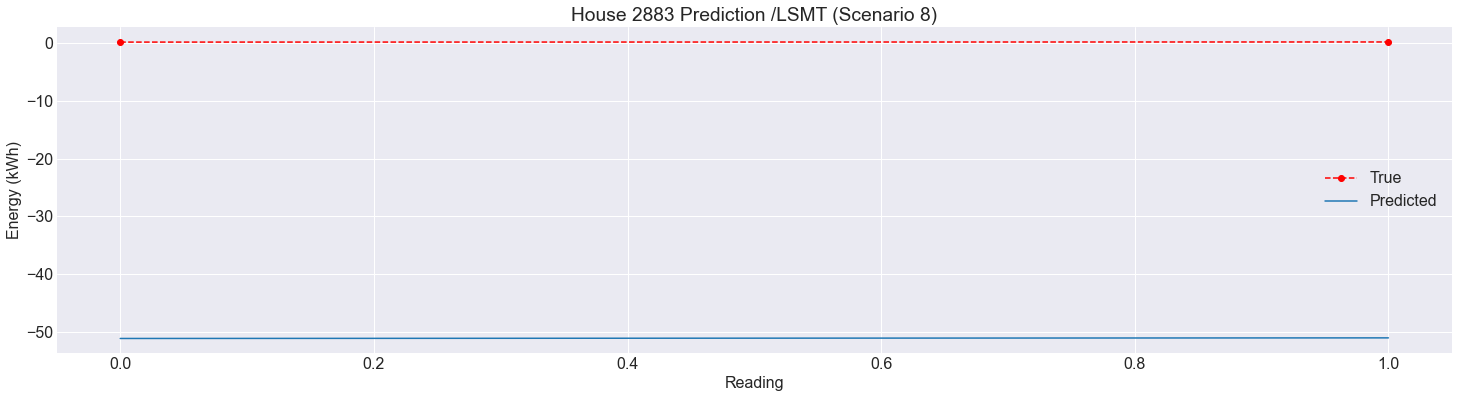

Mse:  1933.475401470955148
Rmse: 43.971302021556689
Mae:  43.971301788464189
Mape:  99.872806191465259


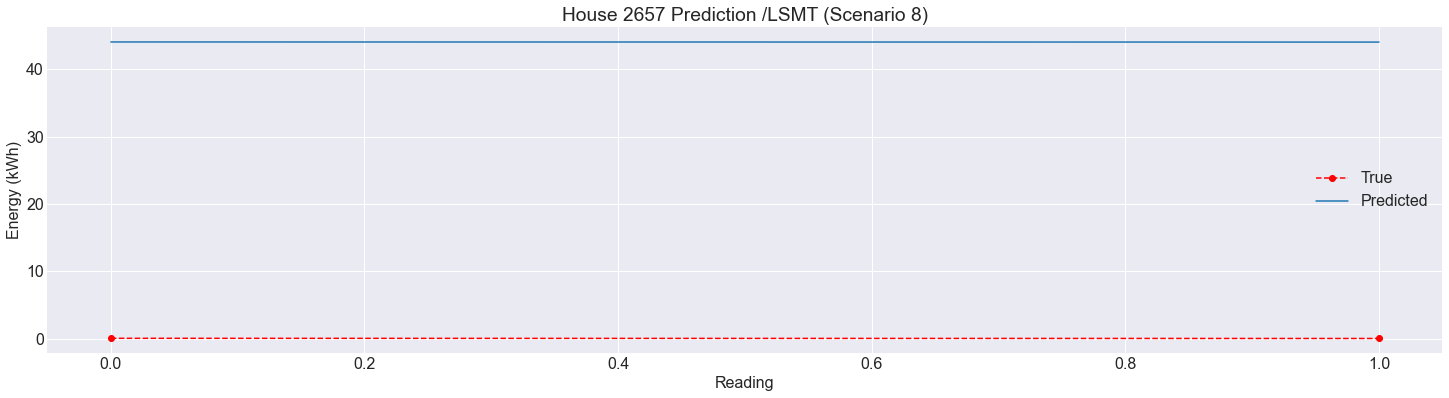

Mse:  2076.280079345715421
Rmse: 45.566216425612026
Mae:  45.566134933382273
Mape:  100.311505008123532


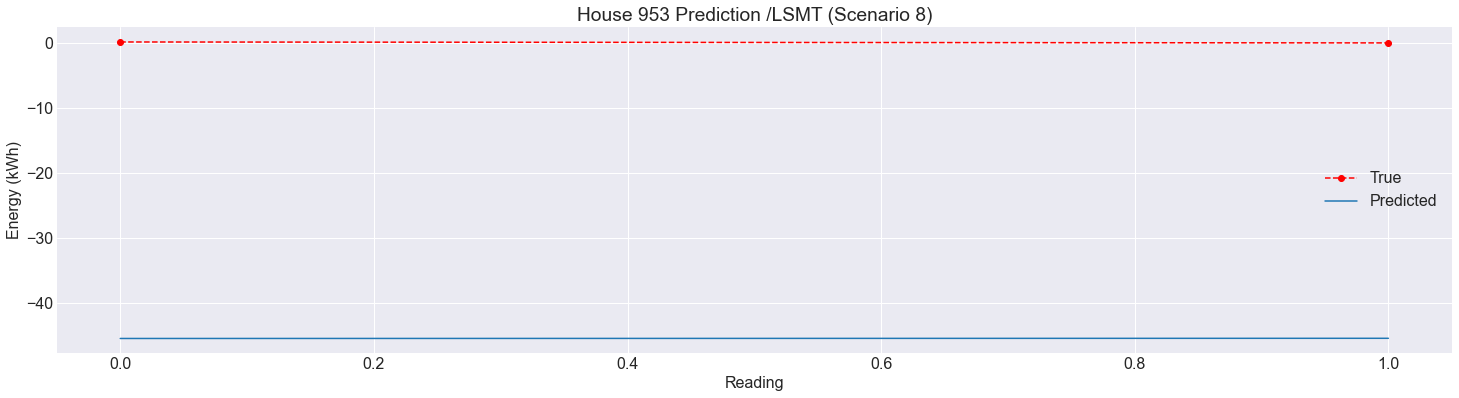

Mse:  492.538235726685684
Rmse: 22.193202466671764
Mae:  22.193199496716261
Mape:  99.504566285843623


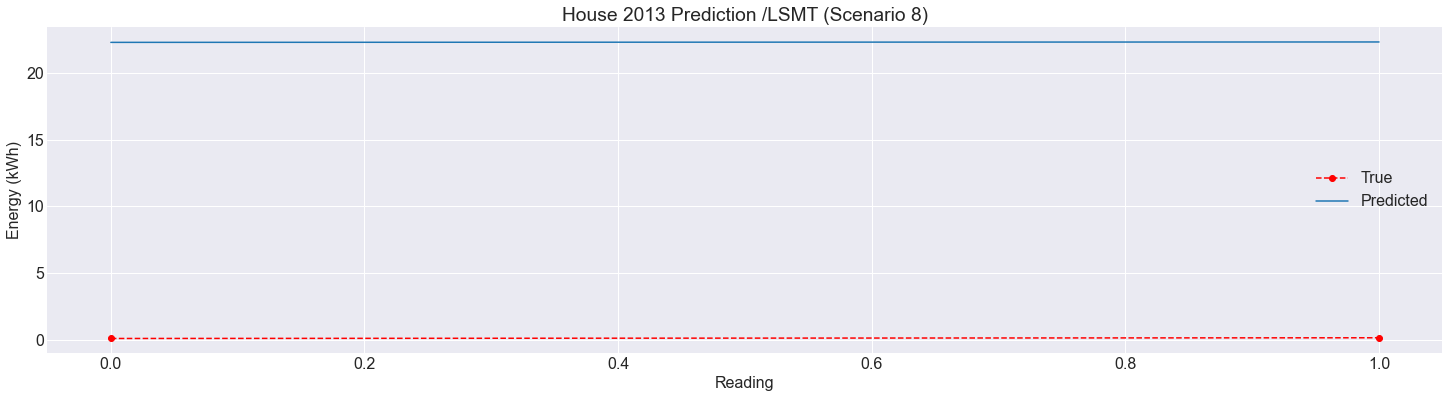

Mse:  13364.372502259378962
Rmse: 115.604379252082737
Mae:  115.604374268092215
Mape:  100.012544353014917


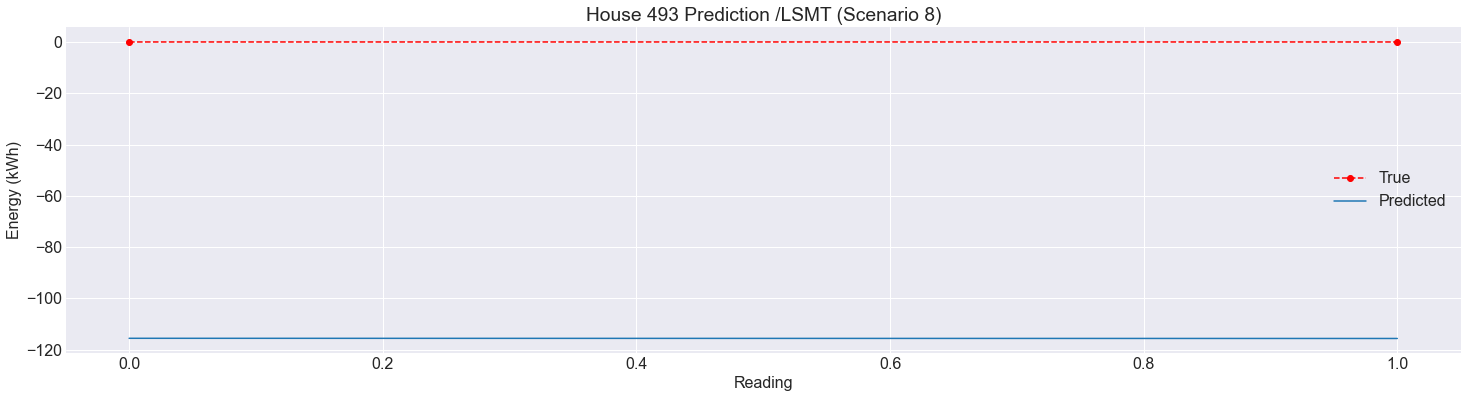

Mse:  1984.770442448355880
Rmse: 44.550762534981999
Mae:  44.550593532621861
Mape:  100.718927428154998


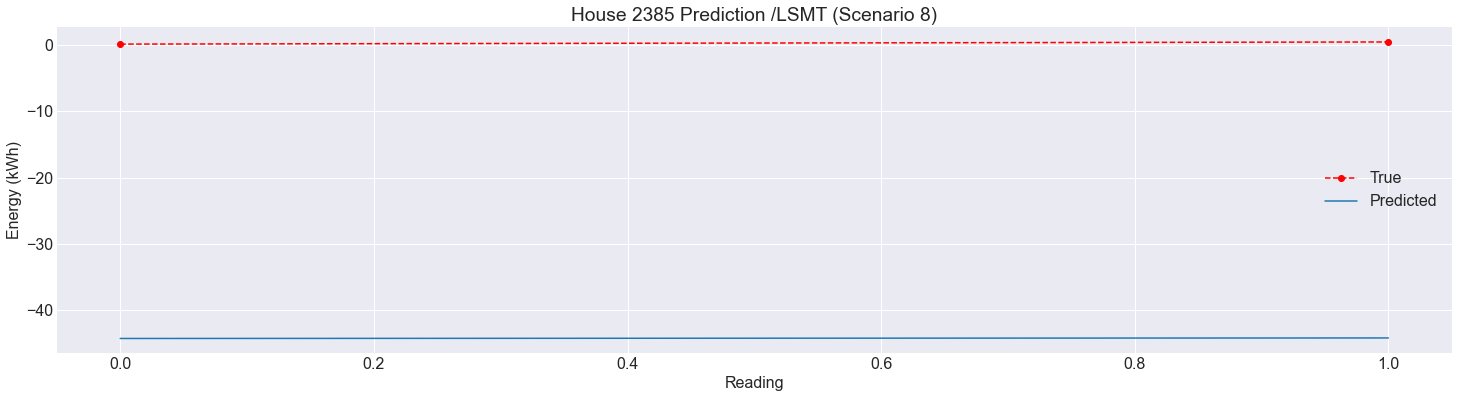

Mse:  3650.110691296311415
Rmse: 60.416145948714004
Mae:  60.407793153077364
Mape:  100.248179109024036


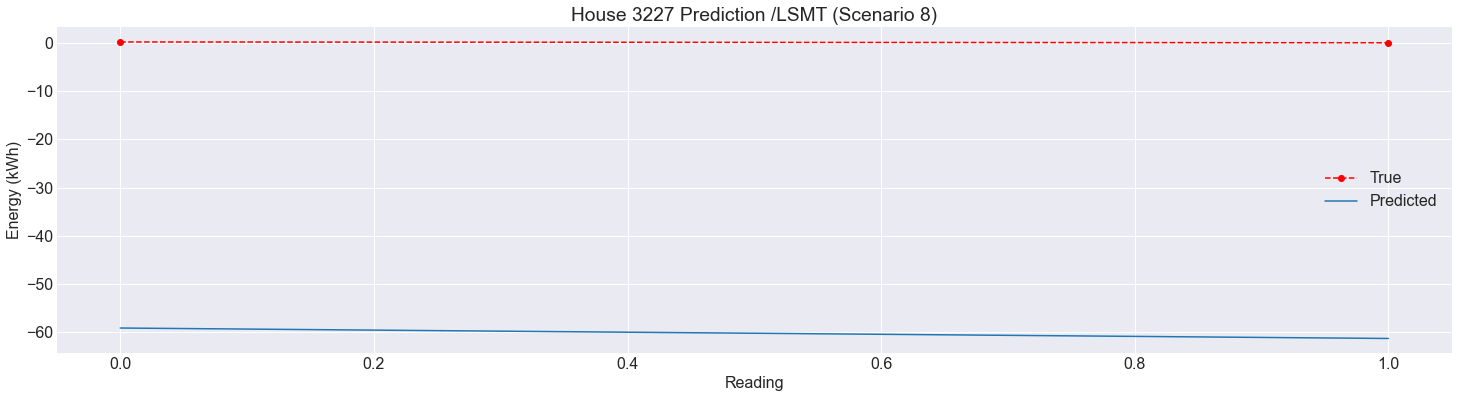

Mse:  75412.951290576282190
Rmse: 274.614186251505032
Mae:  274.614070793613791
Mape:  100.106262098468051


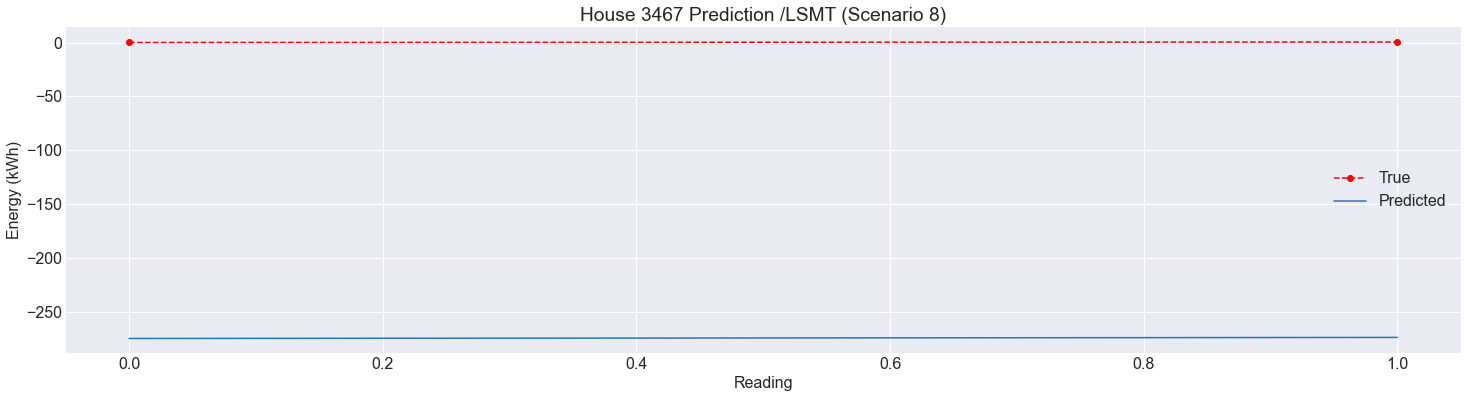

Mse:  264.659129111256334
Rmse: 16.268347460982518
Mae:  16.241925358772278
Mape:  103.178600206026758


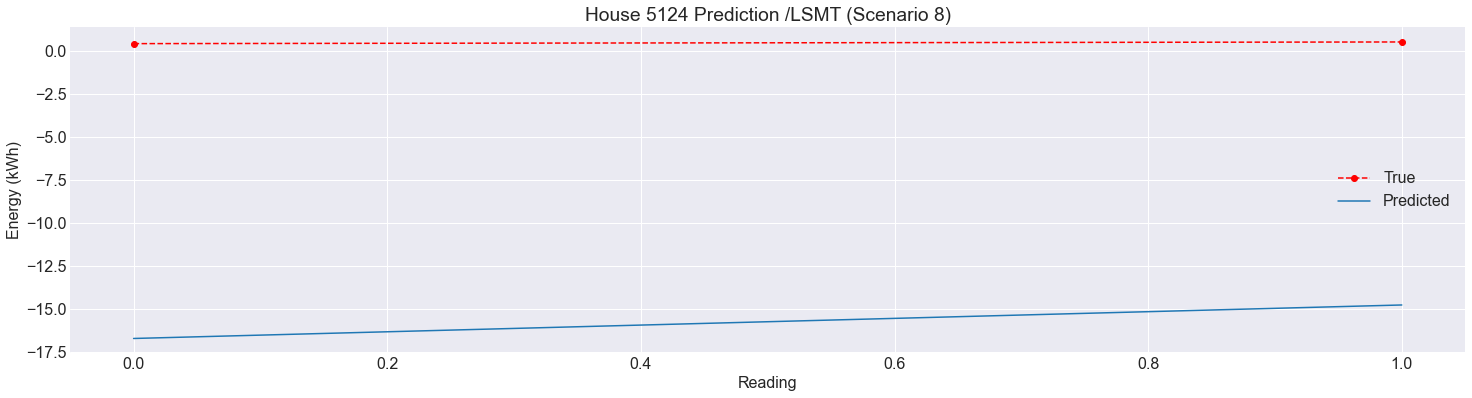

Mse:  8294.873191517221130
Rmse: 91.076194428166687
Mae:  91.075654119253159
Mape:  99.644964948226431


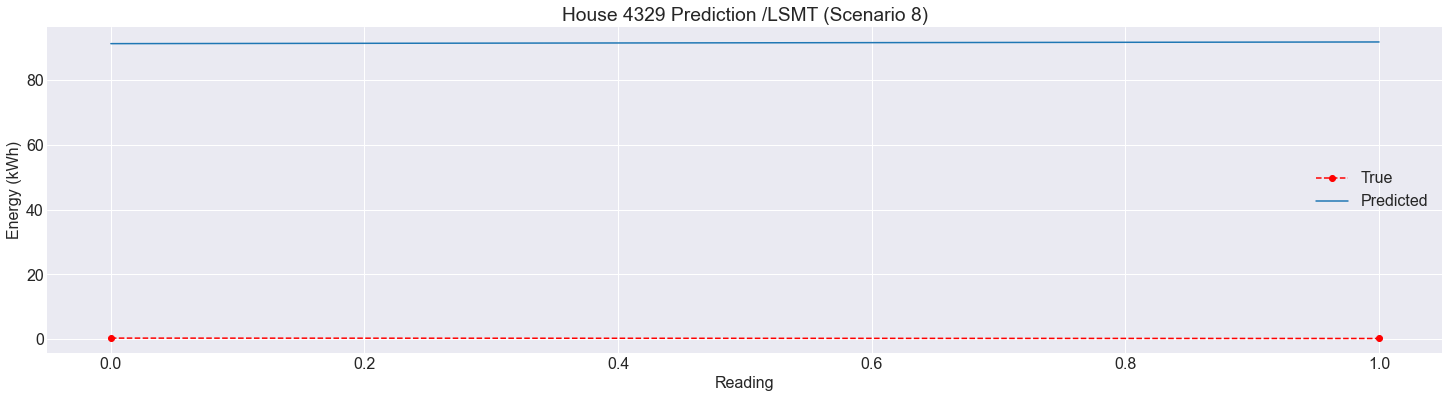

In [116]:
 ##### The households with an error have a '#' 

predict_household_AfterTuning(5492)
predict_household_AfterTuning(2)
predict_household_AfterTuning(3613)
predict_household_AfterTuning(4417)
predict_household_AfterTuning(4957)
predict_household_AfterTuning(3580)
predict_household_AfterTuning(2862)
predict_household_AfterTuning(4539)
predict_household_AfterTuning(336)
predict_household_AfterTuning(3957)
predict_household_AfterTuning(4059)
predict_household_AfterTuning(4151)
predict_household_AfterTuning(754)
predict_household_AfterTuning(1091)
predict_household_AfterTuning(4081)
predict_household_AfterTuning(3430)
predict_household_AfterTuning(3547)
predict_household_AfterTuning(885)
predict_household_AfterTuning(3245)
predict_household_AfterTuning(2883)
predict_household_AfterTuning(2657)
predict_household_AfterTuning(953)
predict_household_AfterTuning(2013)
predict_household_AfterTuning(493)
predict_household_AfterTuning(2385)
predict_household_AfterTuning(3227)
predict_household_AfterTuning(3467)
predict_household_AfterTuning(5124)
predict_household_AfterTuning(4329)



In [ ]:
models_performances_HH_level = pd.DataFrame([MSE_scores_HH, RMSE_scores_HH, MAE_scores_HH, MAPE_scores_HH],
                                   columns=households_predictions, 
                                   index=['MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores'])
models_performances_HH_level

,HH_1,HH_2,HH_3,HH_4,HH_5,HH_6,HH_7,HH_8,HH_9,HH_10,...,HH_20,HH_21,HH_22,HH_23,HH_24,HH_25,HH_26,HH_27,HH_28,HH_29
MSE_scores,1916.195903,3.613432,24085.043460,40298.669023,14430.025295,19160.058140,3861.303692,5388.918216,2139.999002,861.501864,...,5488.500573,8272.505232,5353.885716,363.055654,10578.808050,1940.025343,2055.573955,366.909156,3531.298859,1542.262601
RMSE_scores,43.774375,1.900903,155.193568,200.745284,120.125040,138.419862,62.139389,73.409252,46.260123,29.351352,...,74.084415,90.953313,73.170252,19.054019,102.853333,44.045719,45.338438,19.154873,59.424733,39.271651
MAE_scores,43.774296,1.899166,155.193511,200.742582,120.124974,138.419842,62.136131,73.409245,46.259245,29.327653,...,74.034549,90.952572,73.170199,19.053778,102.851647,44.041943,45.338102,19.154872,59.422935,39.271651
MAPE_scores,99.716393,92.427539,99.788776,100.077524,100.035809,99.925644,99.825672,100.094764,99.553442,100.934498,...,100.309332,100.061610,99.806989,100.583328,100.014100,99.283074,99.671329,98.500771,100.846040,99.180474


In [ ]:
models_performances_HH_level.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/models_performances_HH_level_Scenario4_1h.csv', index=False)

In [ ]:
## Best regression model

In [117]:
MSE_scores_HH = []
RMSE_scores_HH = []
MAE_scores_HH = []
MAPE_scores_HH = []
households_predictions = ['HH_1',
                      'HH_2',
                      'HH_3',
                      'HH_4',
                      'HH_5',
                      'HH_6',
                      'HH_7',
                      'HH_8',
                      'HH_9',
                      'HH_10',
                      'HH_11',
                      'HH_12',
                      'HH_13',
                      'HH_14',
                      'HH_15',
                      'HH_16',
                      'HH_17',
                      'HH_18',
                      'HH_19',
                      'HH_20',
                      'HH_21',
                      'HH_22',
                      'HH_23',
                      'HH_24',
                      'HH_25',
                      'HH_26',
                      'HH_27',
                      'HH_28', 
                      'HH_29']

In [118]:
# tune the Rf parametersbegining with house numbber of your choice 
def predict_household_AfterTuning(num):
  house = updated_houses[updated_houses.LCLid==num]

  np.random.seed(5)
  dataframe = house.loc[:,'energy(kWh/hh)']
  dataset = dataframe.values
  dataset = dataset.astype('float32')

  reframed = series_to_supervised(dataset, 24,1)

  # Select required columns and merge with supervised data
  df=house[weather_energy.columns[1:]]
  df = df[12:]
  reframed = pd.concat([df, reframed], axis=1).dropna()

  reframed = reframed.reindex(reframed.columns, axis=1)
  reframed = reframed.values

  # split into train and test sets''''
  train = reframed[:(len(reframed)-2), :]
  test = reframed[(len(reframed)-2):len(reframed), :]

  #test_X, labels = test[:, :-1], test[:, -1]
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]


  model = LinearSVR(C=8, 
                  dual=False, 
                  epsilon=0.001, loss='squared_epsilon_insensitive') 
  model.fit(train_X, train_y)

  predicted = model.predict(test_X)

  mse_HH = mean_squared_error(predicted,test_y.ravel())
  rmse_HH = mean_squared_error(predicted,test_y.ravel(), squared=False)
  mae_HH = mean_absolute_error(predicted,test_y.ravel())
  mape_HH = mean_absolute_percentage_error(predicted, test_y.ravel())

  print(f'Mse:  {mse_HH:.15f}')
  print(f'Rmse: {rmse_HH:.15f}')
  print(f'Mae:  {mae_HH:.15f}')
  print(f'Mape:  {mape_HH:.15f}')
  #print(f'Training time: {train_time_HH:.3f} s') 

  MSE_scores_HH.append(mse_HH)
  RMSE_scores_HH.append(rmse_HH)
  MAE_scores_HH.append(mae_HH)
  MAPE_scores_HH.append(mape_HH)
#  train_times_HH.append(train_time)

  matplotlib.rcParams.update({'font.size': 16})
  predicted_house = pd.DataFrame({'Predicted':predicted.ravel(),'True Reading':test_y.ravel()})
  predicted_house['True Reading'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
  predicted_house['Predicted'].plot()
  plt.title(f'House {num} Prediction /SVR (Scenario 8)')
  plt.xlabel('Reading')
  plt.ylabel('Energy (kWh)')
  # style

  plt.style.use('seaborn-darkgrid')
  palette = plt.get_cmap('Set1')

  plt.grid(b=True, which='major', color='w', linewidth=1.0)
  plt.legend(['True','Predicted'])
  plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario8/2_singleHouseholdLevel/best_regression_model/S8_1h_SVR_HH'+str(num) + '.jpeg', dpi = 500)
  plt.show()


Mse:  0.001348882160514
Rmse: 0.036727131122840
Mae:  0.032291359012196
Mape:  32.896892988550604


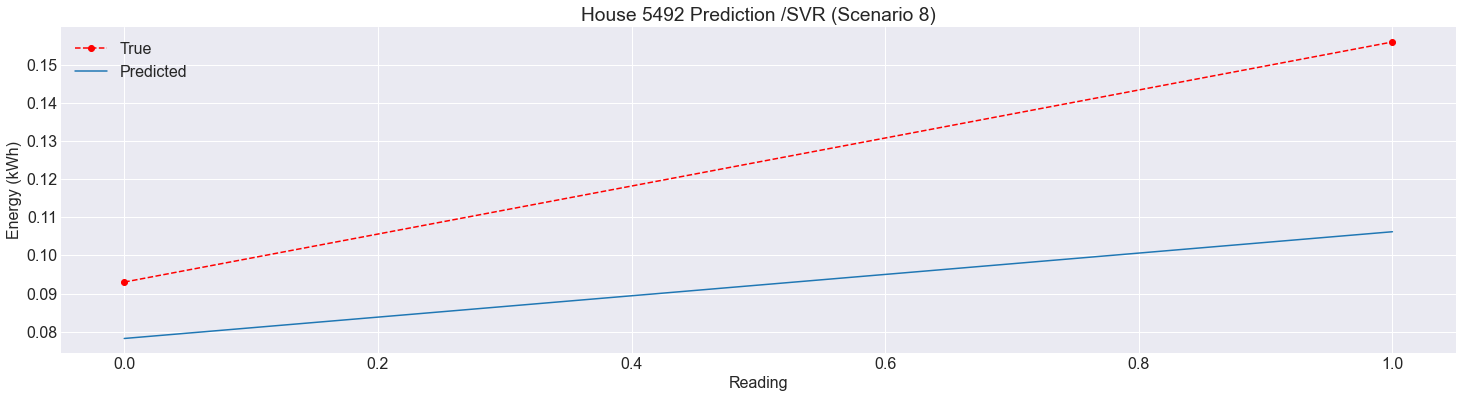

Mse:  0.003454965373827
Rmse: 0.058778953493805
Mae:  0.058749755698224
Mape:  72.199474596294621


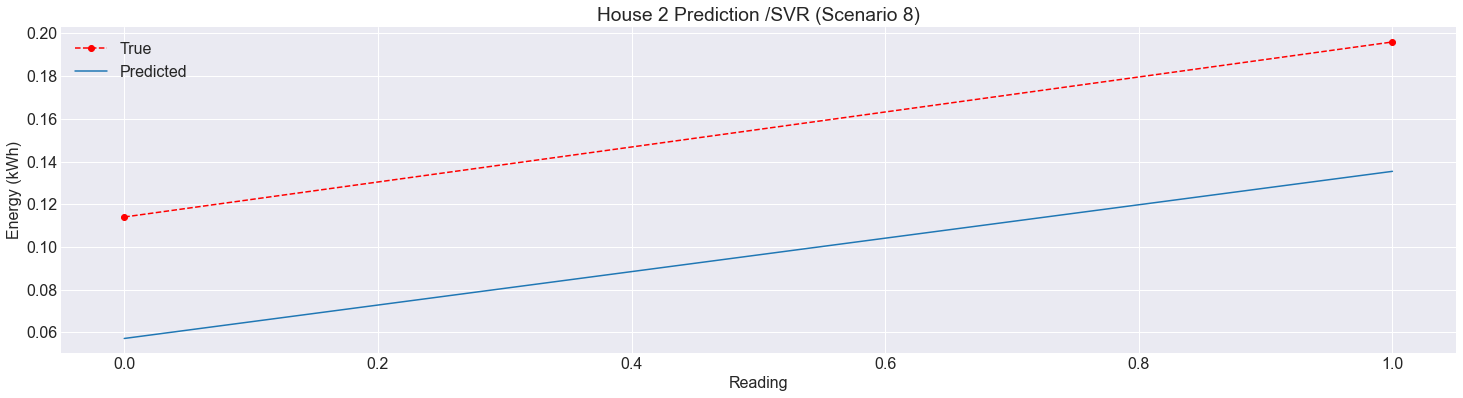

Mse:  0.031458139795789
Rmse: 0.177364426522877
Mae:  0.135197230240229
Mape:  22.923182609915791


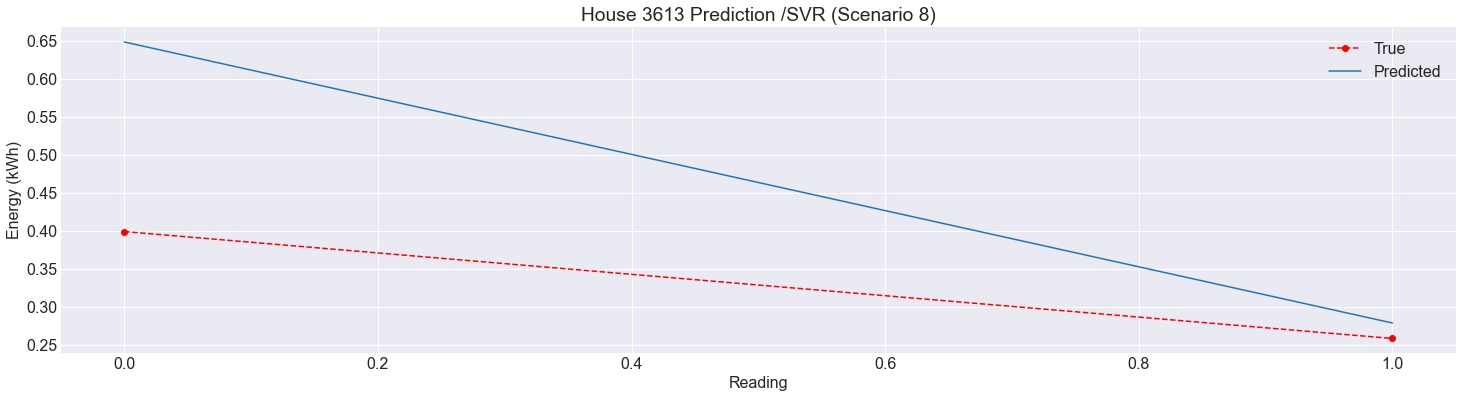

Mse:  0.002113703090402
Rmse: 0.045975026812411
Mae:  0.032636767532603
Mape:  18.863352734058591


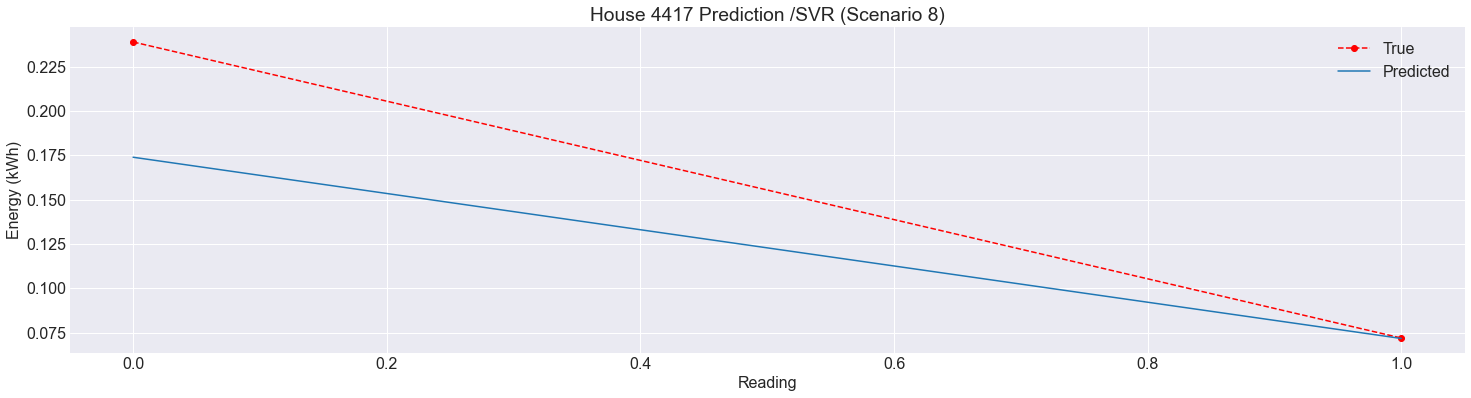

Mse:  0.000041120035697
Rmse: 0.006412490600151
Mae:  0.006256224713657
Mape:  13.961429298454952


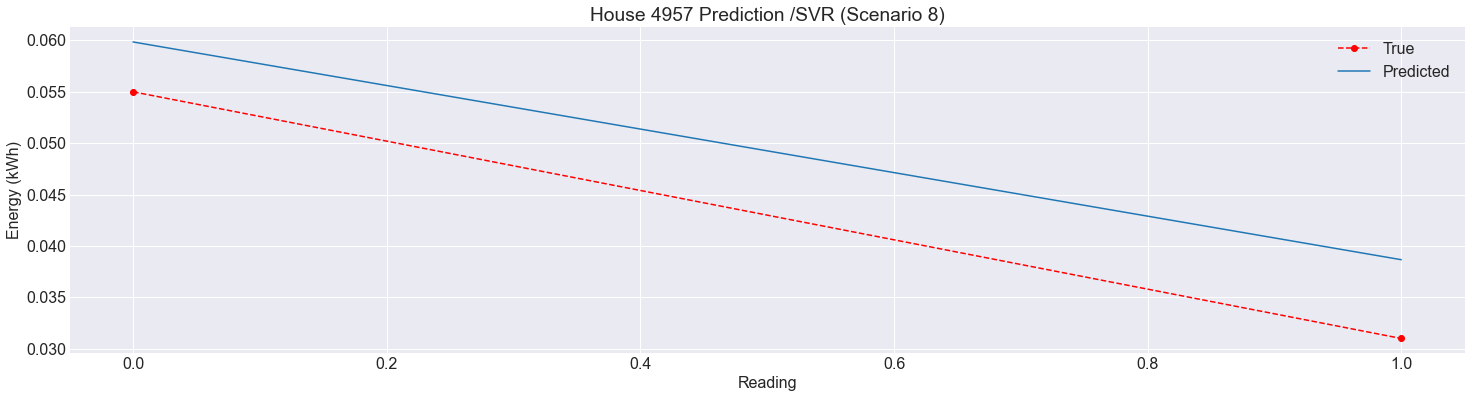

Mse:  0.003613286750787
Rmse: 0.060110620948273
Mae:  0.060035732779784
Mape:  58.000024318816436


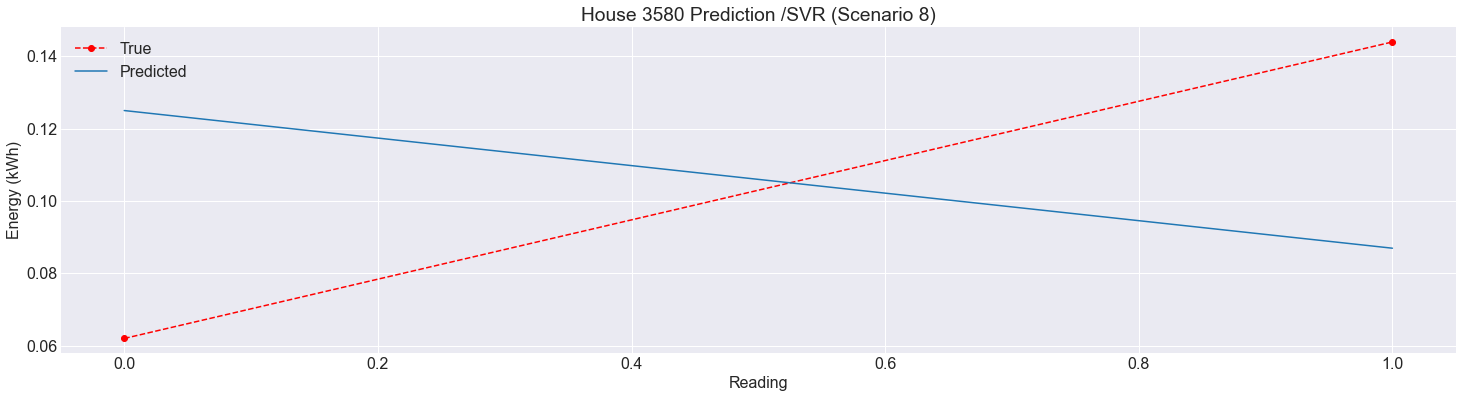

Mse:  0.075015585431916
Rmse: 0.273889732249890
Mae:  0.270919402201482
Mape:  72.264419147893562


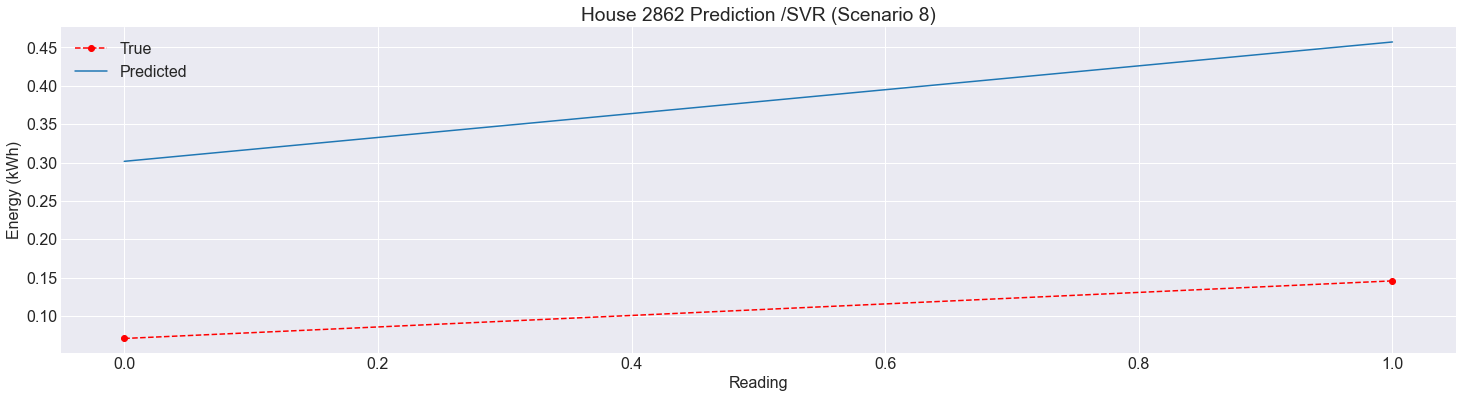

Mse:  0.000848629103985
Rmse: 0.029131239314273
Mae:  0.021635808266524
Mape:  25.256938690168983


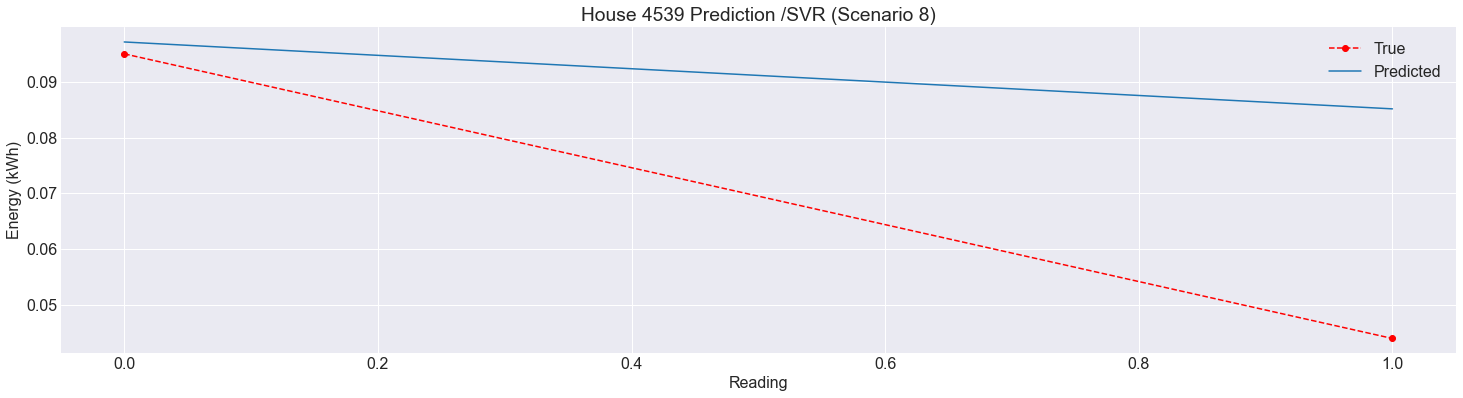

Mse:  0.015042651714745
Rmse: 0.122648488432369
Mae:  0.115221745574882
Mape:  72.063500460960327


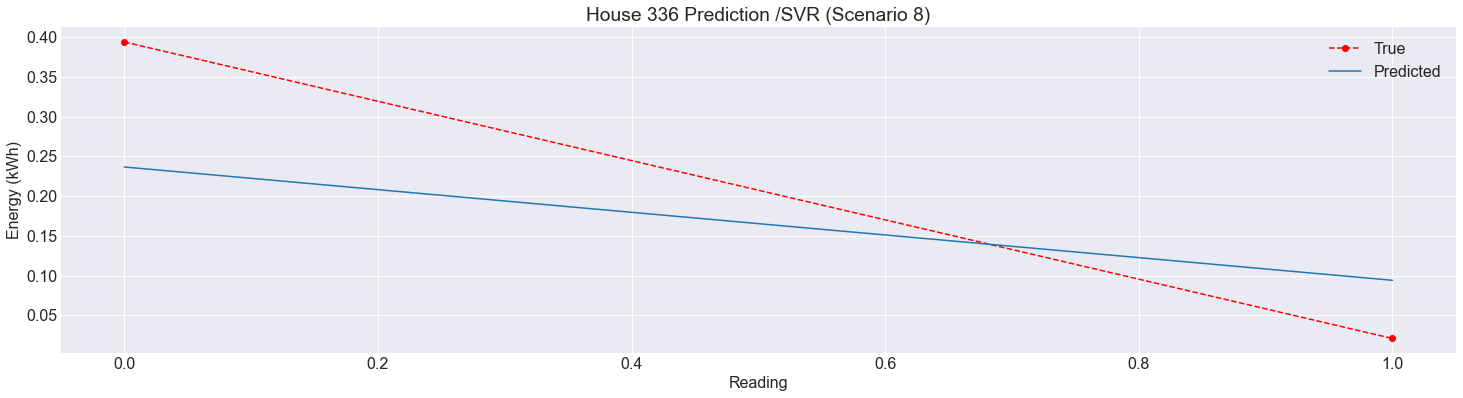

Mse:  0.013046845717125
Rmse: 0.114222789832525
Mae:  0.102797417593125
Mape:  45.876419639348541


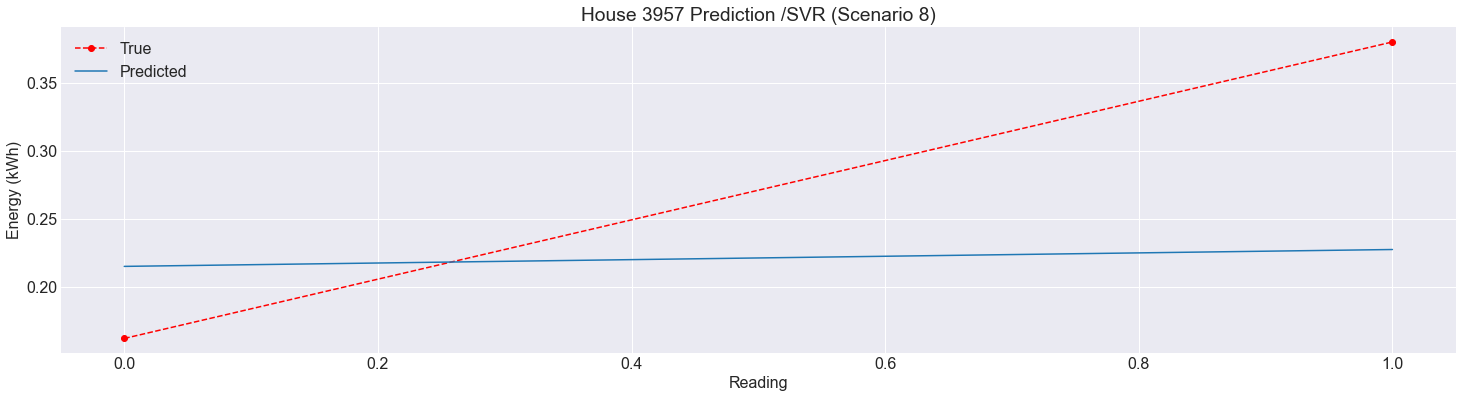

Mse:  0.014157452270207
Rmse: 0.118985092638560
Mae:  0.084203936797351
Mape:  1017.413636468933873


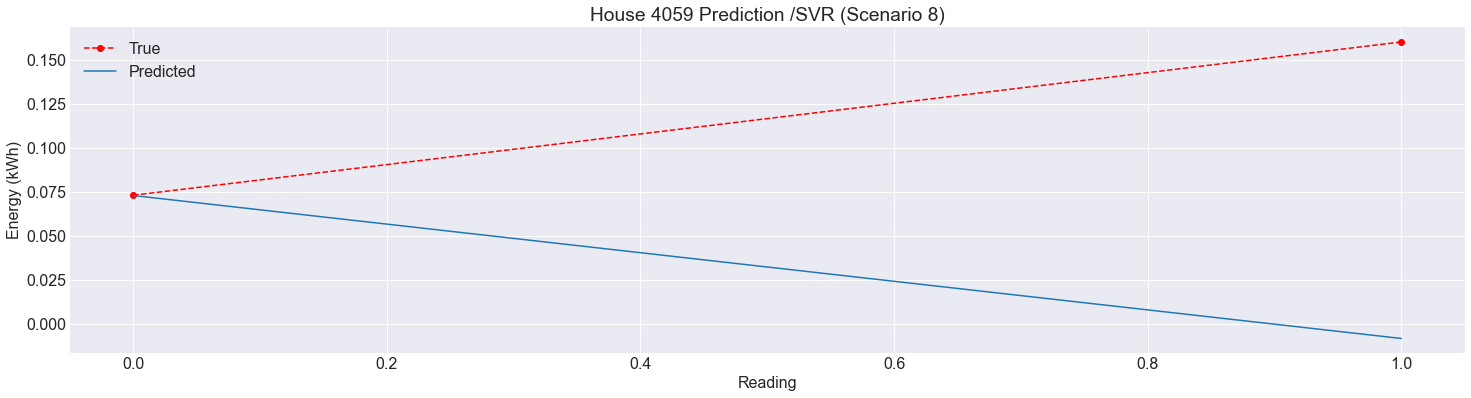

Mse:  0.003407286092456
Rmse: 0.058371963239694
Mae:  0.058146486644862
Mape:  82.183546585155327


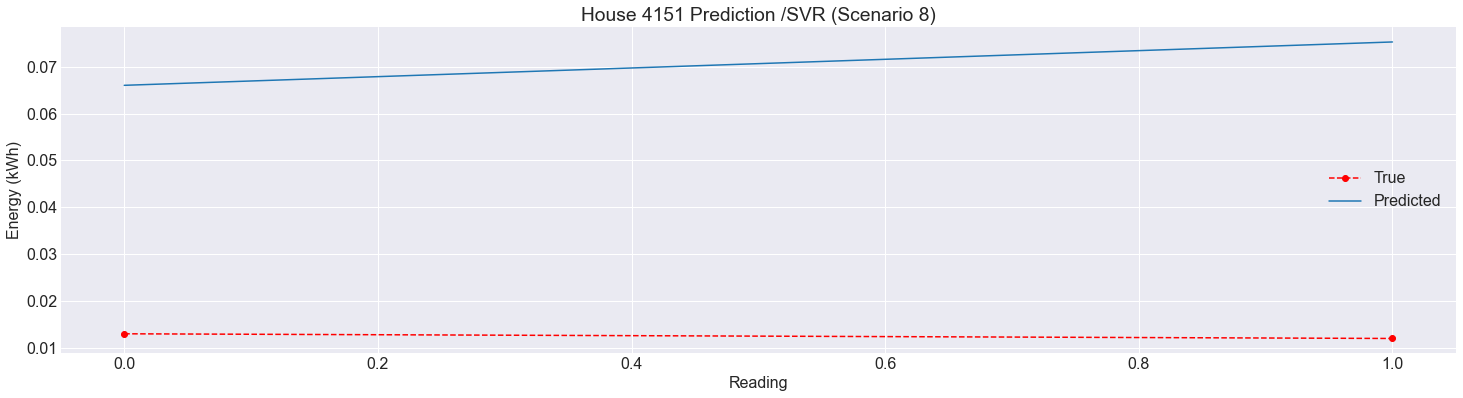

Mse:  0.003728574859651
Rmse: 0.061062057446919
Mae:  0.057354808646974
Mape:  52.584958430807774


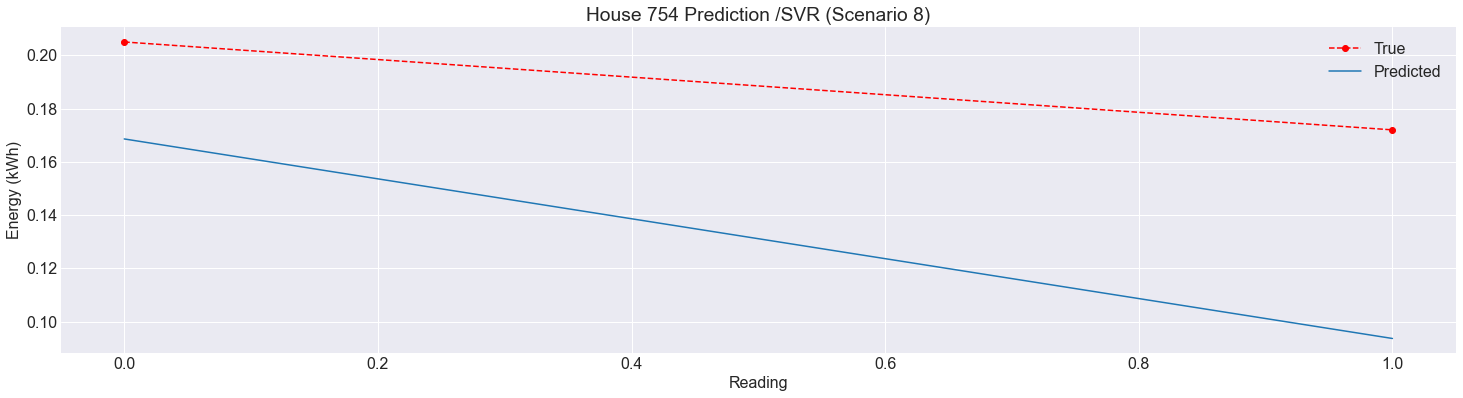

Mse:  0.013132038043056
Rmse: 0.114595104795345
Mae:  0.098378614741360
Mape:  71.842204231384272


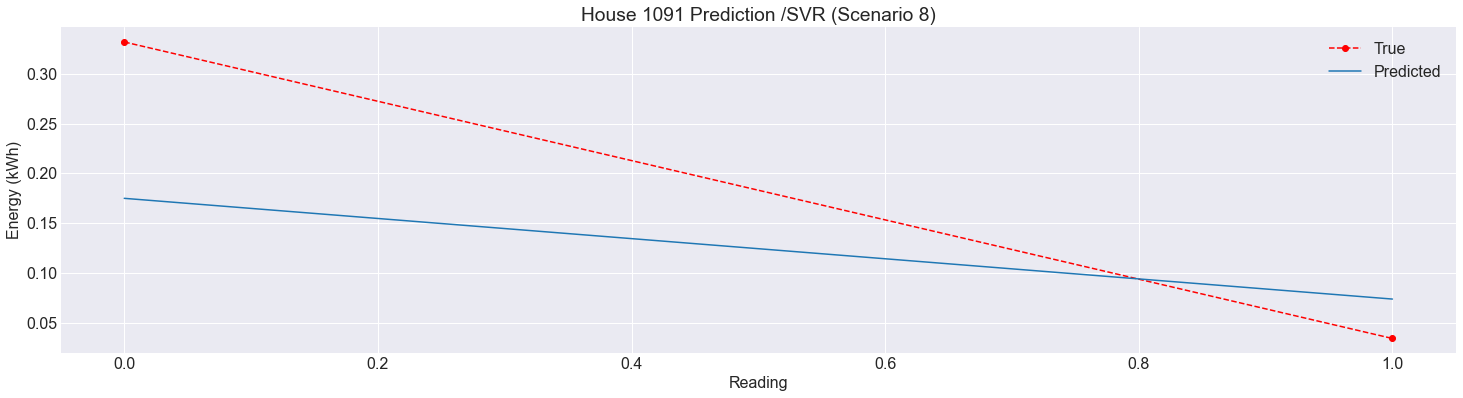

Mse:  0.006831592649497
Rmse: 0.082653449108293
Mae:  0.072890399995829
Mape:  57.696929197275374


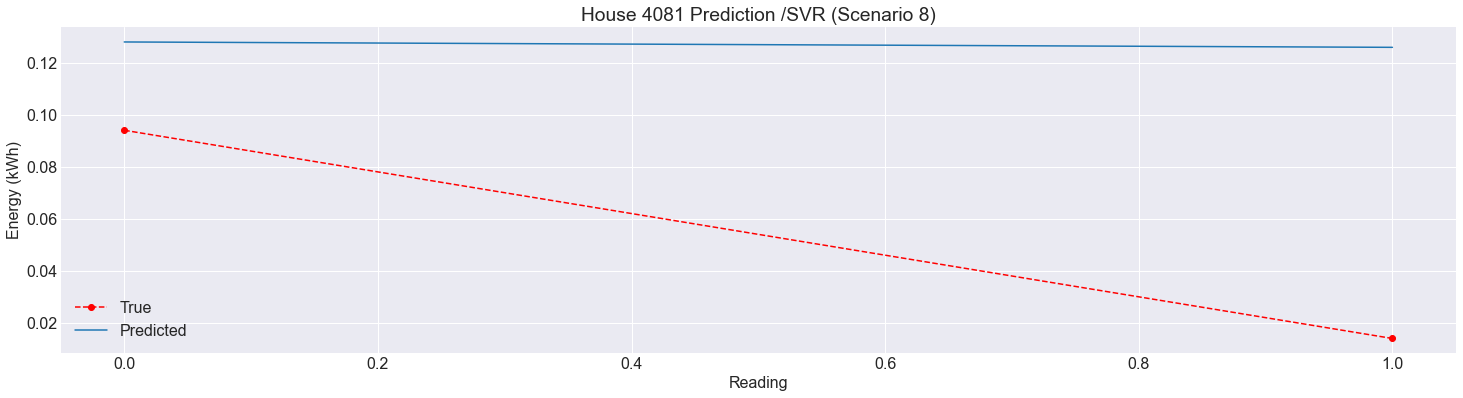

Mse:  0.006521227903312
Rmse: 0.080754120039242
Mae:  0.074863129470874
Mape:  58.504260315546695


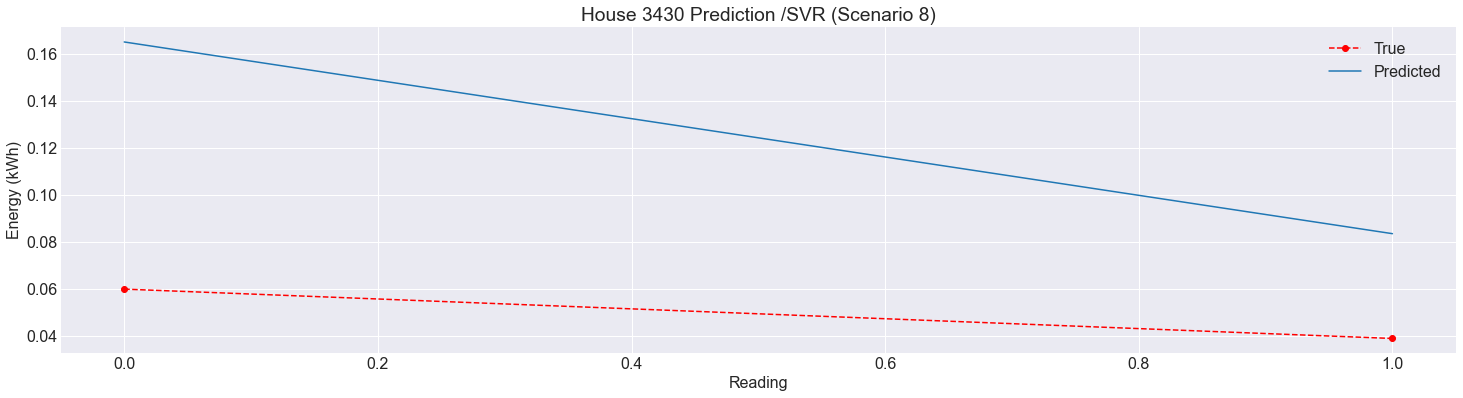

Mse:  0.092616497164232
Rmse: 0.304329586409590
Mae:  0.255979595145292
Mape:  98.451319707558739


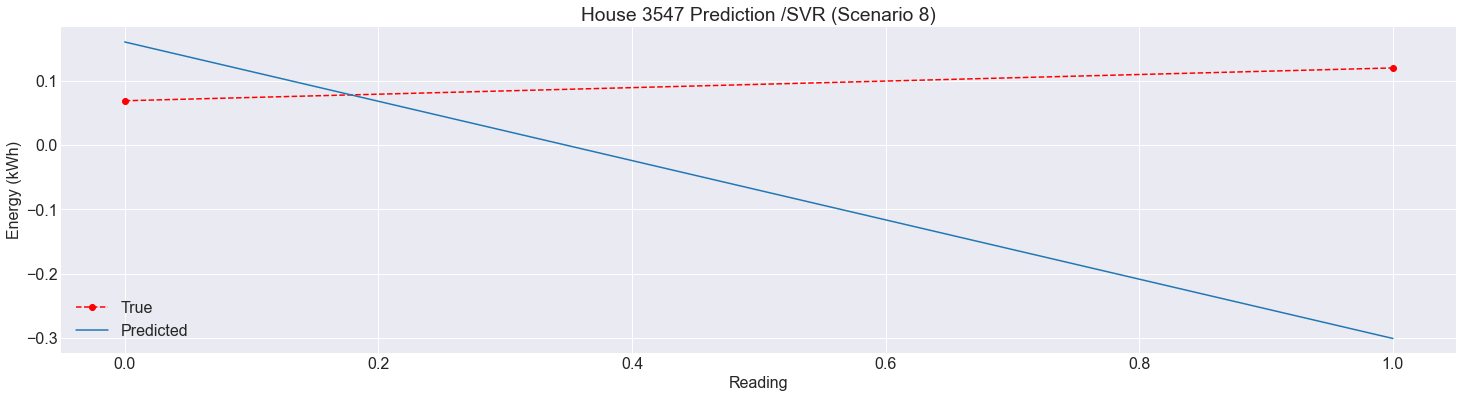

Mse:  0.159222088067787
Rmse: 0.399026425275052
Mae:  0.388872152468205
Mape:  69.502064370969435


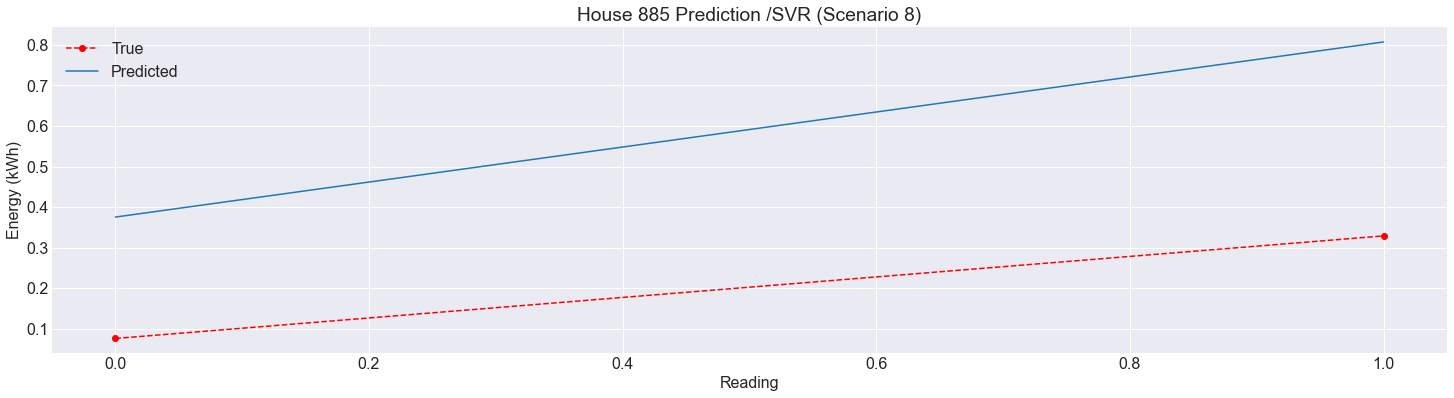

Mse:  0.010892817661796
Rmse: 0.104368662259303
Mae:  0.089983141337231
Mape:  45.065598149632343


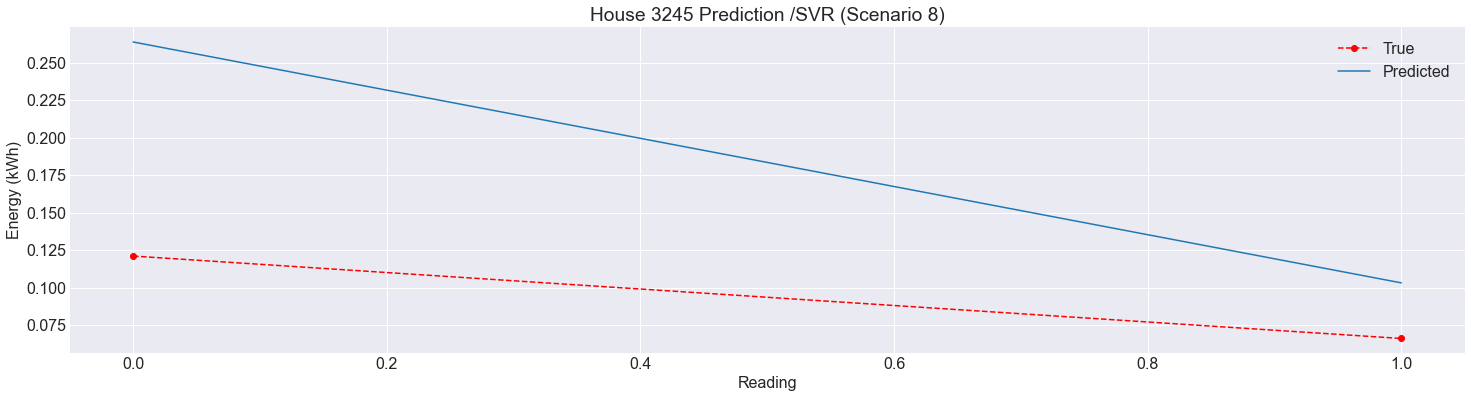

Mse:  0.004952457217965
Rmse: 0.070373696918416
Mae:  0.069781555466443
Mape:  23.454169848646483


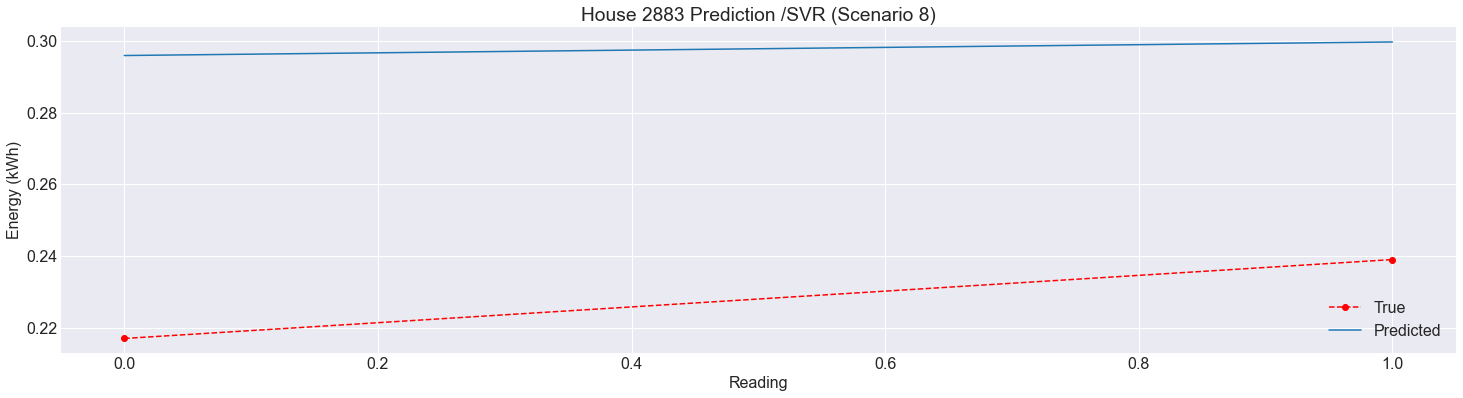

Mse:  0.010985034943740
Rmse: 0.104809517429189
Mae:  0.104797985223879
Mape:  65.574734691511040


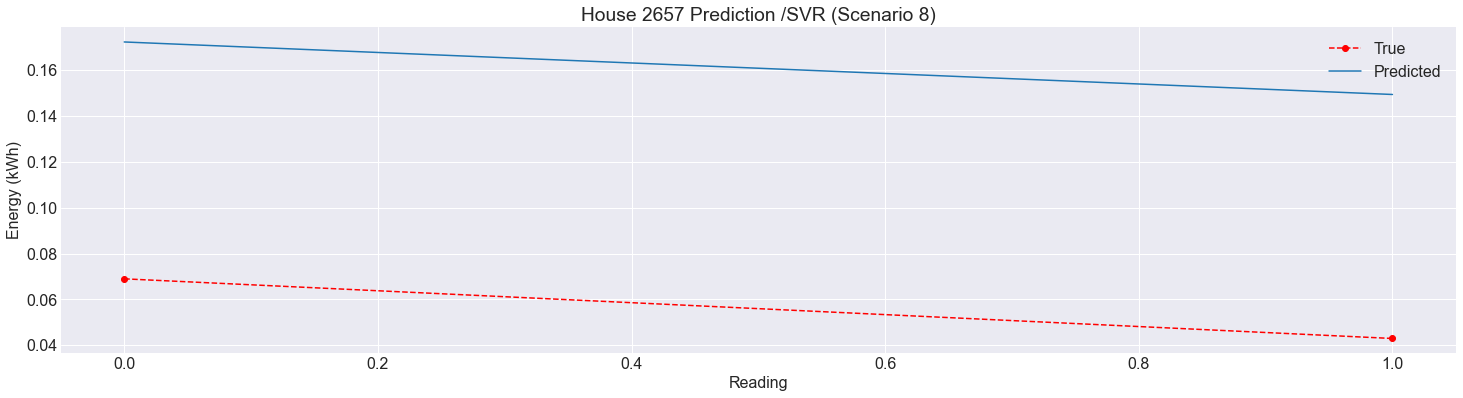

Mse:  0.006139173627367
Rmse: 0.078352878870961
Mae:  0.071906717418480
Mape:  64.996378136074355


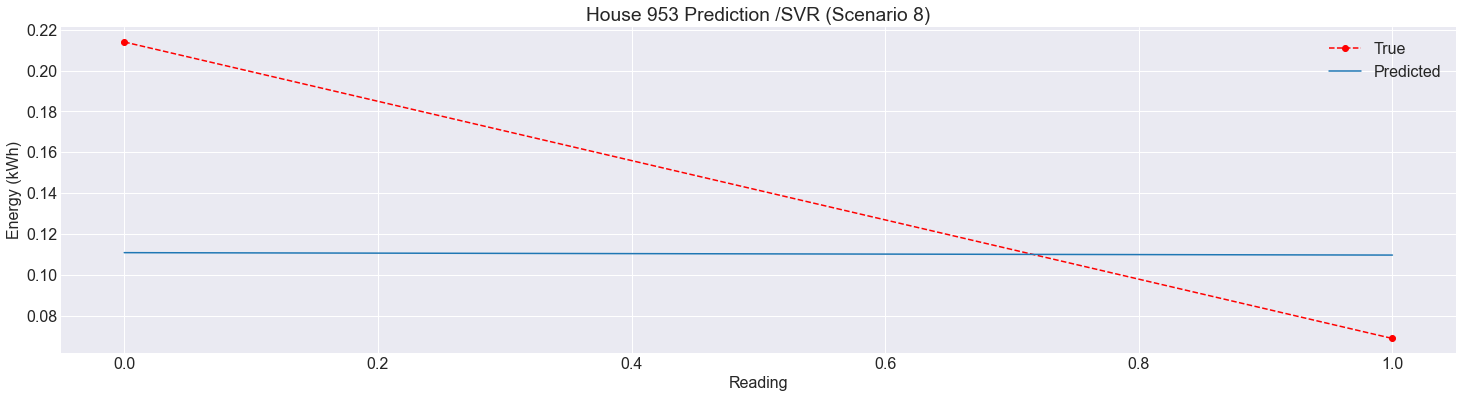

Mse:  0.003499485417017
Rmse: 0.059156448651160
Mae:  0.059154748247773
Mape:  137.152822130296215


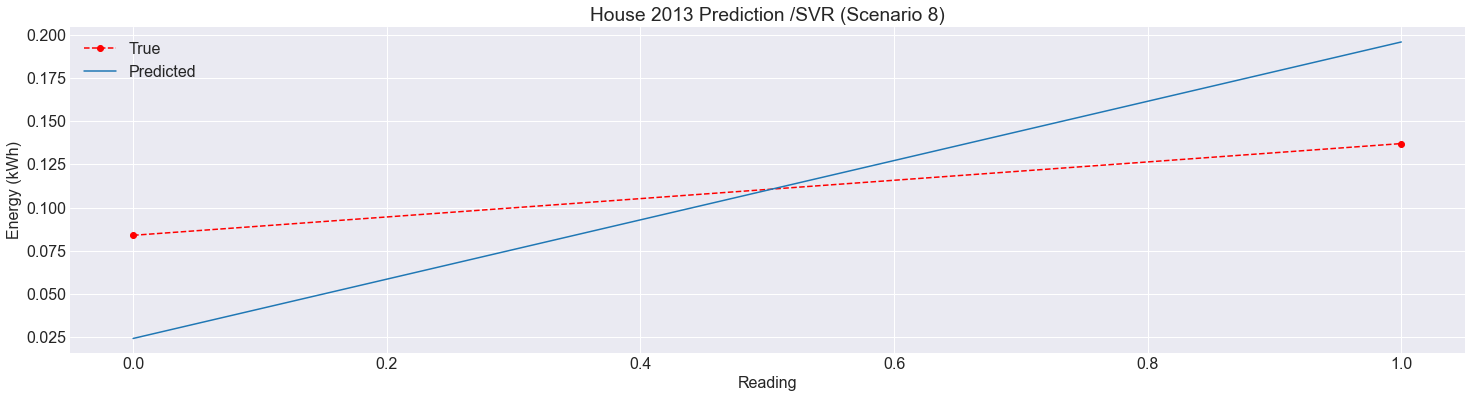

Mse:  0.013578343241154
Rmse: 0.116526148315106
Mae:  0.111989827846838
Mape:  88.000996778757198


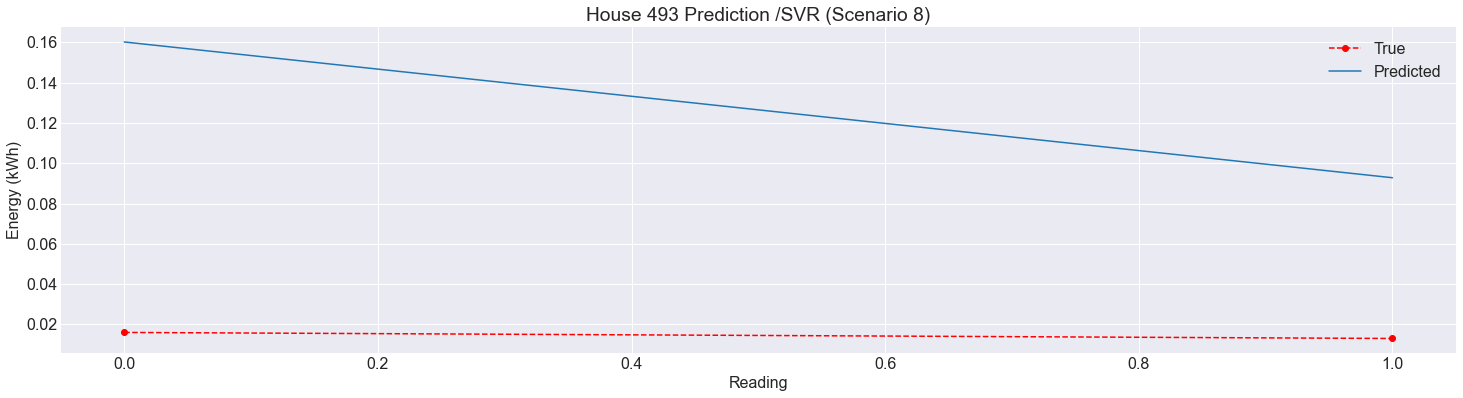

Mse:  0.012960176128416
Rmse: 0.113842769328650
Mae:  0.090854232900449
Mape:  27.489219231837740


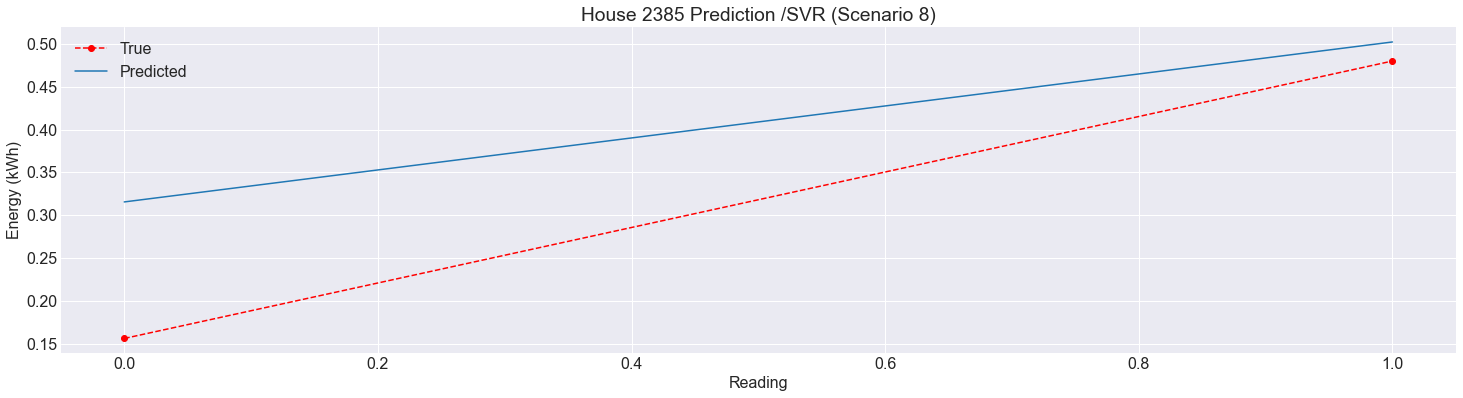

Mse:  0.007691060060665
Rmse: 0.087698689047583
Mae:  0.081291109156215
Mape:  69.916332811895103


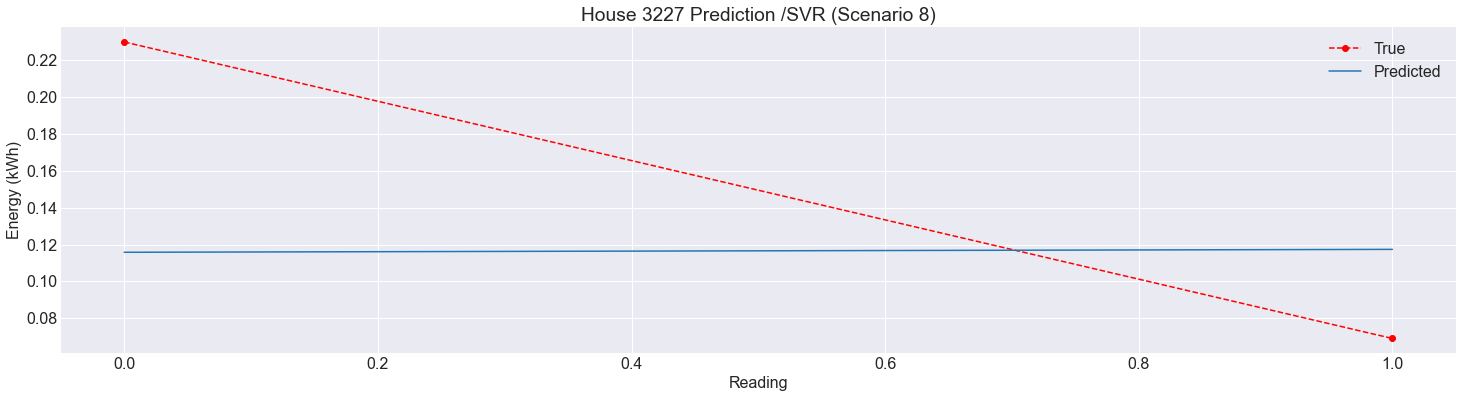

Mse:  0.056961116811098
Rmse: 0.238665281955918
Mae:  0.170062330649948
Mape:  90.670417357251125


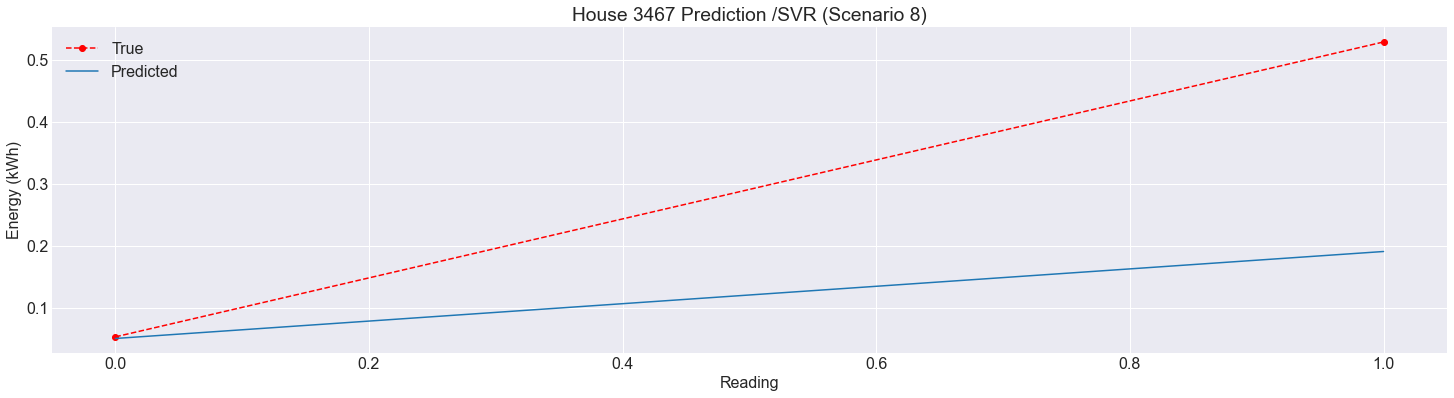

Mse:  0.047101802135825
Rmse: 0.217029496004173
Mae:  0.191382882346057
Mape:  25.727648970483273


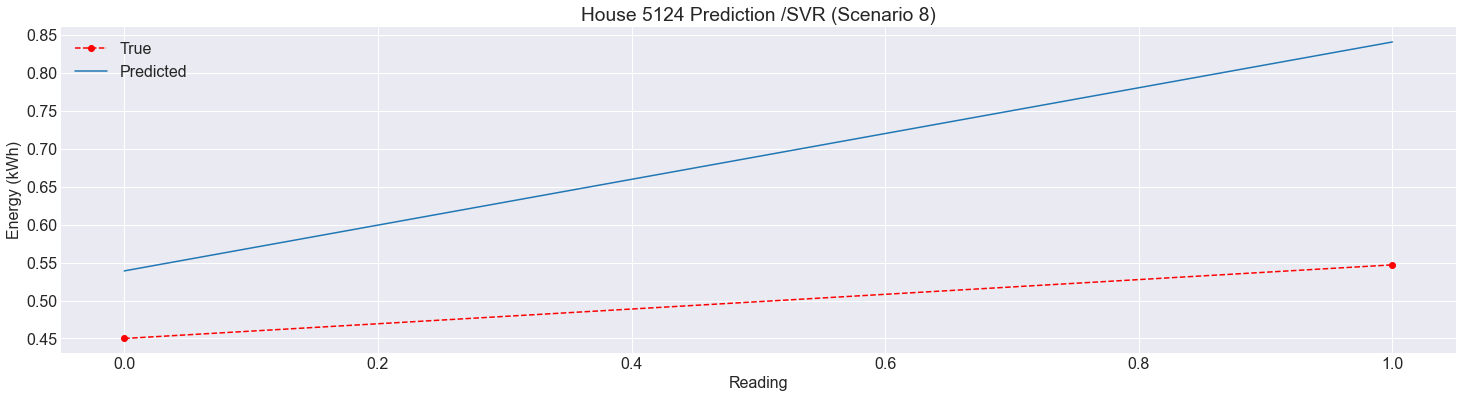

Mse:  0.000335447259886
Rmse: 0.018315219351293
Mae:  0.015185514957790
Mape:  4.521834151402220


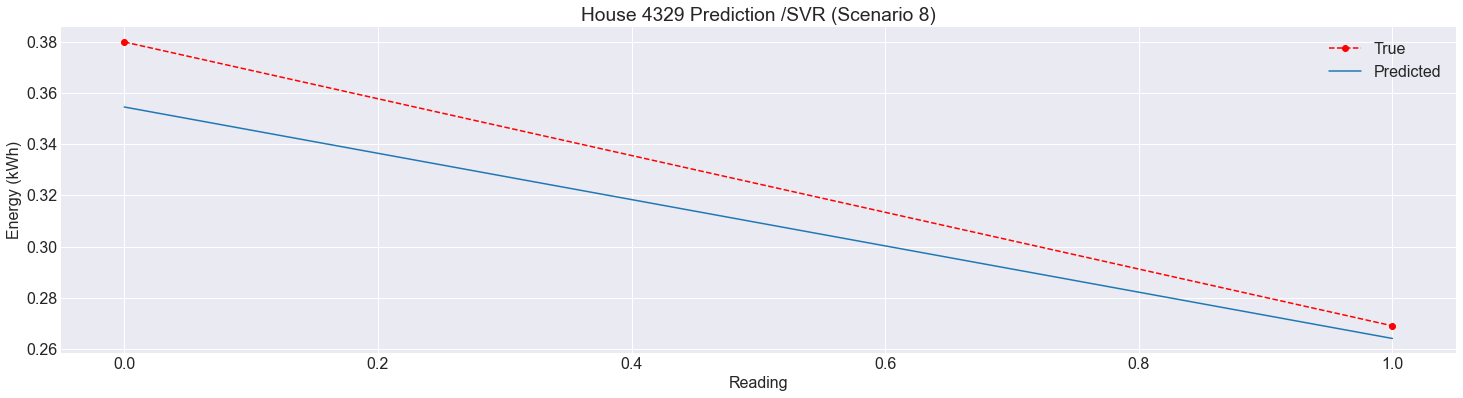

In [119]:
 ##### The households with an error have a '#' 

predict_household_AfterTuning(5492)
predict_household_AfterTuning(2)
predict_household_AfterTuning(3613)
predict_household_AfterTuning(4417)
predict_household_AfterTuning(4957)
predict_household_AfterTuning(3580)
predict_household_AfterTuning(2862)
predict_household_AfterTuning(4539)
predict_household_AfterTuning(336)
predict_household_AfterTuning(3957)
predict_household_AfterTuning(4059)
predict_household_AfterTuning(4151)
predict_household_AfterTuning(754)
predict_household_AfterTuning(1091)
predict_household_AfterTuning(4081)
predict_household_AfterTuning(3430)
predict_household_AfterTuning(3547)
predict_household_AfterTuning(885)
predict_household_AfterTuning(3245)
predict_household_AfterTuning(2883)
predict_household_AfterTuning(2657)
predict_household_AfterTuning(953)
predict_household_AfterTuning(2013)
predict_household_AfterTuning(493)
predict_household_AfterTuning(2385)
predict_household_AfterTuning(3227)
predict_household_AfterTuning(3467)
predict_household_AfterTuning(5124)
predict_household_AfterTuning(4329)




In [ ]:
models_performances_HH_level_Regression = pd.DataFrame([MSE_scores_HH, RMSE_scores_HH, MAE_scores_HH, MAPE_scores_HH],
                                   columns=households_predictions, 
                                   index=['MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores'])
models_performances_HH_level_Regression

,HH_1,HH_2,HH_3,HH_4,HH_5,HH_6,HH_7,HH_8,HH_9,HH_10,...,HH_20,HH_21,HH_22,HH_23,HH_24,HH_25,HH_26,HH_27,HH_28,HH_29
MSE_scores,0.001349,0.003455,0.031458,0.002114,0.000041,0.003613,0.075016,0.000849,0.015043,0.013047,...,0.004952,0.010985,0.006139,0.003499,0.013578,0.012960,0.007691,0.056961,0.047102,0.000335
RMSE_scores,0.036727,0.058779,0.177364,0.045975,0.006412,0.060111,0.273890,0.029131,0.122648,0.114223,...,0.070374,0.104810,0.078353,0.059156,0.116526,0.113843,0.087699,0.238665,0.217029,0.018315
MAE_scores,0.032291,0.058750,0.135197,0.032637,0.006256,0.060036,0.270919,0.021636,0.115222,0.102797,...,0.069782,0.104798,0.071907,0.059155,0.111990,0.090854,0.081291,0.170062,0.191383,0.015186
MAPE_scores,32.896893,72.199475,22.923183,18.863353,13.961429,58.000024,72.264419,25.256939,72.063500,45.876420,...,23.454170,65.574735,64.996378,137.152822,88.000997,27.489219,69.916333,90.670417,25.727649,4.521834


In [ ]:
models_performances_HH_level_Regression.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/models_performances_HH_level_Scenario4_1h_SVR.csv', index=False)